In [129]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from dateutil.parser import parse
from datetime import datetime
import random
# ------------  PREPROCESING -------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
# Metrics --------------------------------------------------------------
from sklearn.metrics import mean_squared_error, r2_score

In [130]:
# Load the Dataset
df_rating_books_raw = pd.read_csv('../data/processed/filtered_data_processed.csv')

df_rating_books_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      15738 non-null  int64  
 1   review          15738 non-null  float64
 2   text            15738 non-null  object 
 3   review_year     15738 non-null  int64  
 4   publisher       15738 non-null  object 
 5   categories      15738 non-null  object 
 6   published_year  15738 non-null  int64  
 7   helpfulness     15738 non-null  float64
 8   num_row         15738 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 1.1+ MB


In [131]:
df_rating_books_processed = df_rating_books_raw.drop(['Unnamed: 0'], axis=1)

In [132]:
df_vader_sentiment_raw = pd.read_csv('../data/processed/df_reduced_with_sentiment.csv')

df_vader_sentiment_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          15738 non-null  int64  
 1   num_row             15738 non-null  int64  
 2   text_clean          15738 non-null  object 
 3   compound_sentiment  15738 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 491.9+ KB


In [133]:
df_vader_sentiment_processed = df_vader_sentiment_raw.drop(['Unnamed: 0'], axis=1)
df_vader_sentiment_processed.sample()

num_row  \
12838    12838   

                                                                                                                                                  text_clean  \
12838  great book beautiful story finally finished night read straight hour wife friend read loved girl book took awhile pick moved tear made laugh inspired   

       compound_sentiment  
12838              0.9744

In [134]:
df_all_data_processed = df_rating_books_processed.merge(df_vader_sentiment_processed, on='num_row', how='inner')
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              15738 non-null  float64
 1   text                15738 non-null  object 
 2   review_year         15738 non-null  int64  
 3   publisher           15738 non-null  object 
 4   categories          15738 non-null  object 
 5   published_year      15738 non-null  int64  
 6   helpfulness         15738 non-null  float64
 7   num_row             15738 non-null  int64  
 8   text_clean          15738 non-null  object 
 9   compound_sentiment  15738 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.2+ MB


In [135]:
#Original Text is removed as clean text is added
df_all_data_processed = df_all_data_processed.drop(['text'], axis=1)
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              15738 non-null  float64
 1   review_year         15738 non-null  int64  
 2   publisher           15738 non-null  object 
 3   categories          15738 non-null  object 
 4   published_year      15738 non-null  int64  
 5   helpfulness         15738 non-null  float64
 6   num_row             15738 non-null  int64  
 7   text_clean          15738 non-null  object 
 8   compound_sentiment  15738 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 1.1+ MB


In [136]:
df_all_data_processed = df_all_data_processed.drop(['num_row'], axis=1)
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              15738 non-null  float64
 1   review_year         15738 non-null  int64  
 2   publisher           15738 non-null  object 
 3   categories          15738 non-null  object 
 4   published_year      15738 non-null  int64  
 5   helpfulness         15738 non-null  float64
 6   text_clean          15738 non-null  object 
 7   compound_sentiment  15738 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 983.8+ KB


In [137]:
df_all_data_processed.sample(10)

review  review_year       publisher categories  published_year  \
3585      5.0         2011           Other    Fiction            2008   
8006      1.0         2009    Random House      Other            2005   
13193     4.0         2006           Other    Cooking            2004   
13490     3.0         2010           Other      Other            2010   
10653     4.0         2006           Other      Other            2006   
7811      3.0         2013           Other    Fiction            2009   
1045      5.0         2012           Other      Other            2004   
1217      5.0         2007    Random House      Other            2005   
6996      4.0         2013  Harper Collins    Fiction            2009   
3817      1.0         2008         Penguin  Self-Help            2006   

       helpfulness  \
3585      1.000000   
8006      0.250000   
13193     1.000000   
13490     1.000000   
10653     0.674419   
7811      1.000000   
1045      1.000000   
1217      0.000000   
6996      1.000000   
3817      0.833333   

                                                                                                                                                  text_clean  \
3585   reviewer described background event samurai garden writing flawless flow like clear water smooth stone like silk like finest sand hourglass make e...   
8006   hoax book written fifteen year thing writing good book take year right teenager would know plus christopher father happened publishing business te...   
13193  variety taste every everyone easy follow recipies nutritional summary recommended portion size recommendation different week post surgery differen...   
13490  interested keeping pair goat purchased book tractor supply virginia caught attention thick detailed read enjoyed storey guide llama chicken contai...   
10653             good book solid based fact convincing little passionate subject justifies fascinated stile though could written lawyer rather screenwriter   
7811                                                                   book could confusing would better read couple time look word story creative inspiring   
1045   book comprehensive simple entertaining indispensable anybody outdoors beginning advanced scout aware thought book provided online free format list...   
1217   book farm facing evil world find blue dragon change life forever change brings unrest empire whole action highly recommend book people interested ...   
6996                           jodi picoult tackle difficult subject knowledge sensitivity keep turning page enlarge sympathy family teen dealing life share   
3817   latest pucky slop sure topic conversation dullard people need learn honest mysticism jesus mammal self awareness learn nature stop thinking lying ...   

       compound_sentiment  
3585               0.9022  
8006               0.8271  
13193              0.5719  
13490              0.2023  
10653              0.9083  
7811               0.7717  
1045               0.9100  
1217               0.0240  
6996               0.2960  
3817               0.8834

In [138]:
# def custom_string_to_list(s):
#     if isinstance(s, str):
#         return [item.strip(" '[]") for item in s.split(',')]
#     else:
#         return s

In [139]:
# df_all_data_processed['categories'] = df_all_data_processed['categories'].apply(custom_string_to_list)

In [140]:
ordered_columns = ['categories', 'publisher', 'published_year', 'review_year', 'helpfulness', 'text_clean','compound_sentiment', 'review']

In [141]:
df_all_data_processed = df_all_data_processed[ordered_columns]

In [142]:
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   categories          15738 non-null  object 
 1   publisher           15738 non-null  object 
 2   published_year      15738 non-null  int64  
 3   review_year         15738 non-null  int64  
 4   helpfulness         15738 non-null  float64
 5   text_clean          15738 non-null  object 
 6   compound_sentiment  15738 non-null  float64
 7   review              15738 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 983.8+ KB


In [143]:
df_all_data_processed.sample(10)

categories           publisher  published_year  review_year  \
7180     History               Other            2004         2005   
10832      Other      Harper Collins            2005         2007   
4642     Fiction               Other            2005         2006   
1163       Other               Other            2012         2013   
10772      Other  Simon and Schuster            2007         2009   
7874       Other               Other            2005         2007   
2          Other  Simon and Schuster            2004         2012   
8636     Fiction               Other            2012         2013   
3998     Fiction  Simon and Schuster            2009         2011   
6278       Other        Random House            2005         2005   

       helpfulness  \
7180      0.727273   
10832     1.000000   
4642      0.555556   
1163      0.000000   
10772     0.000000   
7874      0.875000   
2         1.000000   
8636      1.000000   
3998      1.000000   
6278      0.720000   

                                                                                                                                                  text_clean  \
7180   natural fascination happening behind scene certainly extends secret diplomacy underway resolve urgent crisis seizure hostage embassy tehran harris...   
10832  listened recorded book unabridged version tape narrated author treat sure must better reading cried sometimes giggled belly laughed many reviewed ...   
4642   cassie parker artist title raised fire brimstone preacher father told would hell everything inculcated brain unable feel anything anyone best frie...   
1163                               bought bible picture amazon site daughter asked pink bible bible sent different cover adverstising bible green pink cover   
10772                    child favorite john lithgow book song funny catchy tune illustration beautiful problem thought getting hardback edition turn amazon   
7874   sandburg took criticism filling blank imagination biography lincoln intended scholarly treatise think mystic atmosphere campfire night elder telli...   
2                                                                                        interesting informative spot good book read want bush family really   
8636   pretty good book glad wrong julie husband hank like first guessed going real story represented growth maturity young adulthood time history marria...   
3998   heard great thing scarpetta series wanted started reading fell behind series already book released another people right series good wish started r...   
6278   book beautiful unique direction conceals utter predictability poor writing author idea borrowed story extremely frustrating featuring guessed comi...   

       compound_sentiment  review  
7180              -0.6494     2.0  
10832              0.9136     5.0  
4642              -0.2911     3.0  
1163               0.1779     2.0  
10772              0.8316     3.0  
7874               0.5267     5.0  
2                  0.7096     5.0  
8636               0.8555     4.0  
3998               0.9524     4.0  
6278               0.1316     1.0

In [144]:
df_all_data_processed['publisher'] = pd.Categorical(df_all_data_processed['publisher'])
df_all_data_processed['categories'] = pd.Categorical(df_all_data_processed['categories'])

In [145]:
df_final = df_all_data_processed.copy()
df_final.to_csv('../data/final/df_final.csv')

# Train Test Split


In [146]:
#Divide Data Set into Train Test Datasets
X = df_final.copy().drop(['review'], axis=1)
y = df_final['review'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1530) #stratify: para definir los datasets de forma proporcional acorde a y.

X_train.sample(5)

categories           publisher  published_year  review_year  \
3092       Other        Random House            2005         2005   
6837       Other        Random House            2012         2013   
11615      Other               Other            2006         2009   
10951    Fiction               Other            2008         2009   
3757     Fiction  Simon and Schuster            2007         2007   

       helpfulness  \
3092           0.5   
6837           1.0   
11615          1.0   
10951          0.0   
3757           1.0   

                                                                                                                                                  text_clean  \
3092   dragon quill person like seven review targeted view exactly eragon best book book awesome tell suppose fast paced keep turning page wondering happ...   
6837                                                        love discworld novel read starting beginning going read would definitely recommend author anyone   
11615  even given difference topic stiff spook latter much enjoyable steady style voice stiff roach swing goofy personal familiarity objective prose beco...   
10951  title austrian proverb tall poppy book tall poppy size relate book thankfully stalk grown reach heavenward flower bloomed brilliant color back boo...   
3757                                amazing read read every time book must anyone going life experience want know right thing billingsley written great book   

       compound_sentiment  
3092               0.9826  
6837               0.8934  
11615              0.3400  
10951              0.9822  
3757               0.8481

In [147]:
df_train = X_train.copy()
df_train['review'] = y.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11803 entries, 1226 to 14826
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   categories          11803 non-null  category
 1   publisher           11803 non-null  category
 2   published_year      11803 non-null  int64   
 3   review_year         11803 non-null  int64   
 4   helpfulness         11803 non-null  float64 
 5   text_clean          11803 non-null  object  
 6   compound_sentiment  11803 non-null  float64 
 7   review              11803 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(1)
memory usage: 669.3+ KB


# Analysis and EDA for target feature

In [148]:
df_train['review'].value_counts()

review
5.0    6970
4.0    2408
3.0    1052
1.0     761
2.0     612
Name: count, dtype: int64

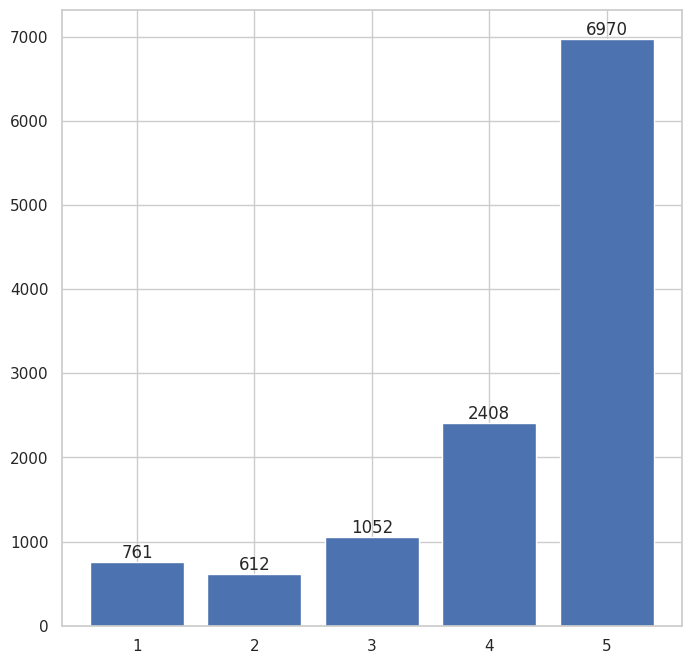

In [149]:
fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['review'].value_counts(ascending=True).keys(), df_train['review'].value_counts(ascending=True))
ax.bar_label(bars)
plt.show()

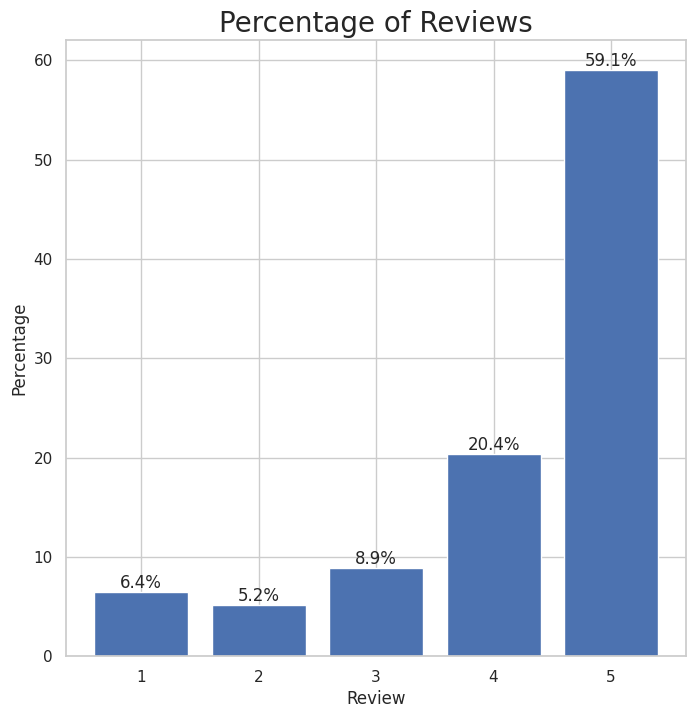

In [150]:
#Show a barplot by Percentages
fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['review'].value_counts(ascending=True).keys(), (df_train['review'].value_counts(ascending=True))/(df_train['review'].value_counts(ascending=True).sum())*100)

# Set the bar labels (percentages) to be displayed above the bars
ax.bar_label(bars, fmt='%.1f%%')

plt.xlabel('Review')
plt.ylabel('Percentage')
plt.title('Percentage of Reviews', fontsize = 20)
plt.show()

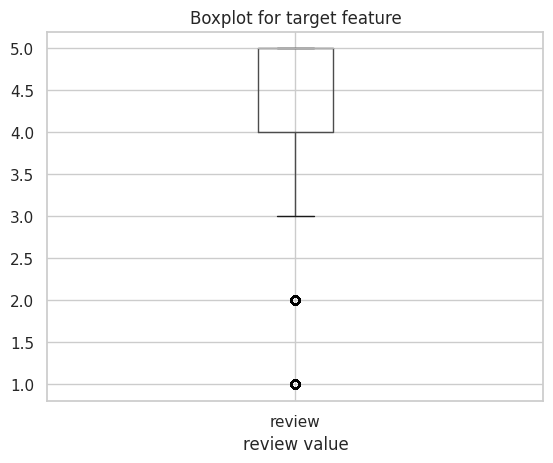

In [151]:
#Create a box plot to check for outliers, median and quartiles
df_train.boxplot(column='review')
plt.xlabel("review value")
plt.title("Boxplot for target feature")
plt.show()

In [152]:
df_train['review'].describe().T

count    11803.000000
mean         4.204270
std          1.194041
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review, dtype: float64

## Key Findings:
- The Dataset is unbalanced. Having 79.5% of the entries with a High/Postive review [4, 5]. Only 11.6% of the entries have a Low/Negative review [1, 2]. And 8.9% of the entries reviews are neutral [3]
- The Dataset review target feature is biased. Having the 25% Quartile above 4, and 50% and 75% Quartiles on 5. 
- The entries on the dataset with a low review [1, 2] are almost considered as outliers on the boxplot.

# Univariate EDA

## Categories

In [153]:
categories = df_train['categories']
categories.info()

<class 'pandas.core.series.Series'>
Index: 11803 entries, 1226 to 14826
Series name: categories
Non-Null Count  Dtype   
--------------  -----   
11803 non-null  category
dtypes: category(1)
memory usage: 104.1 KB


In [154]:
print(f'Total of Categories: {len(categories.unique())}')

Total of Categories: 10


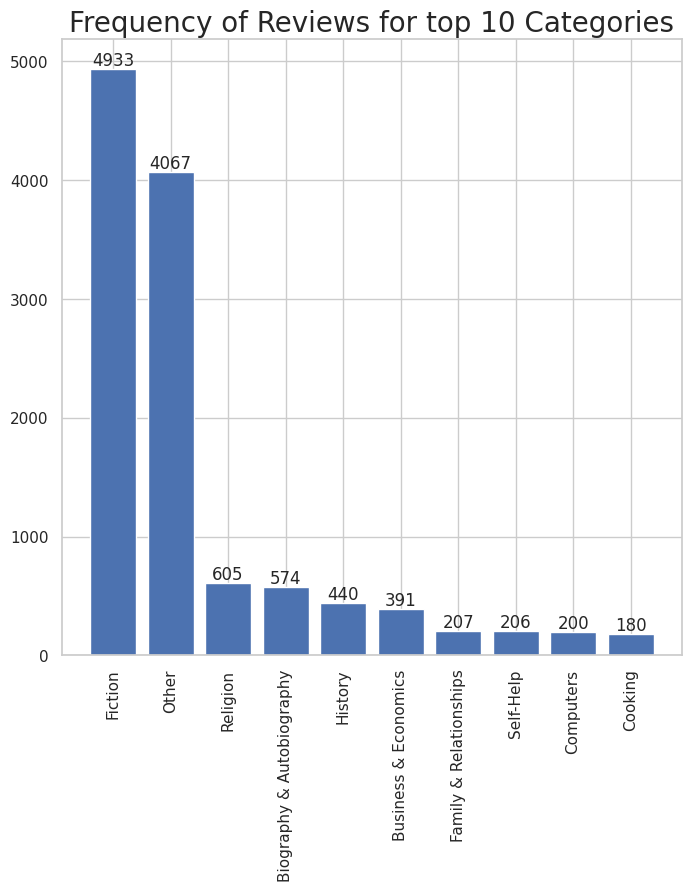

In [155]:
fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['categories'].value_counts(ascending=False).keys(), df_train['categories'].value_counts(ascending=False))
# Set the bar labels (percentages) to be displayed above the bars
ax.bar_label(bars)
plt.title('Frequency of Reviews for top 10 Categories', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

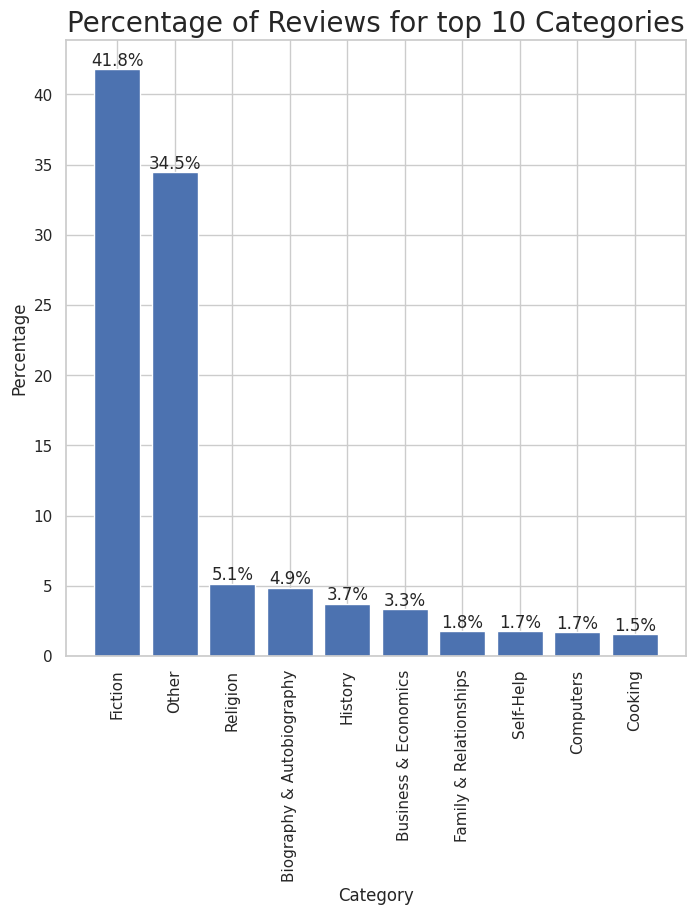

In [156]:
#Show a barplot by Percentages
category_percetage = df_train['categories'].value_counts(ascending=False)/df_train['categories'].value_counts(ascending=False).sum()*100

fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['categories'].value_counts(ascending=False).keys(), category_percetage)

# Set the bar labels (percentages) to be displayed above the bars
ax.bar_label(bars, fmt='%.1f%%')

plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Percentage of Reviews for top 10 Categories', fontsize = 20)
plt.show()

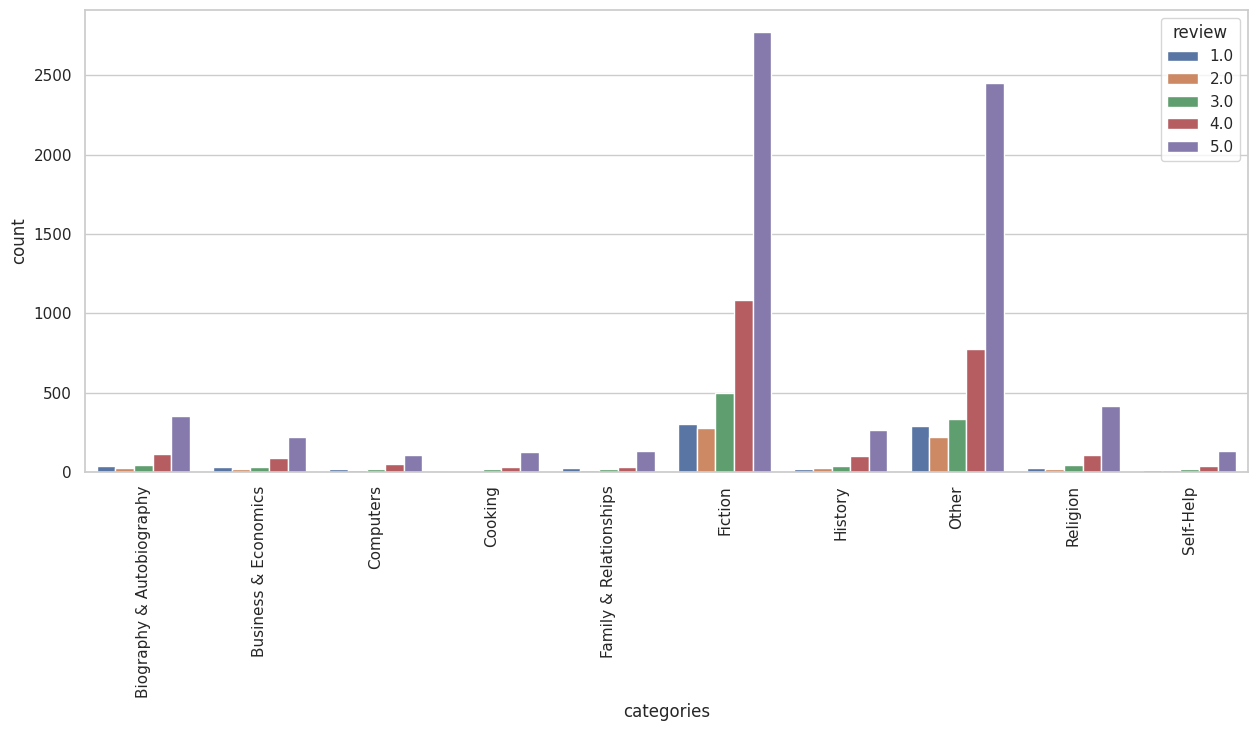

In [157]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df_train, x = 'categories', hue='review')
plt.xticks(rotation=90)
plt.show()

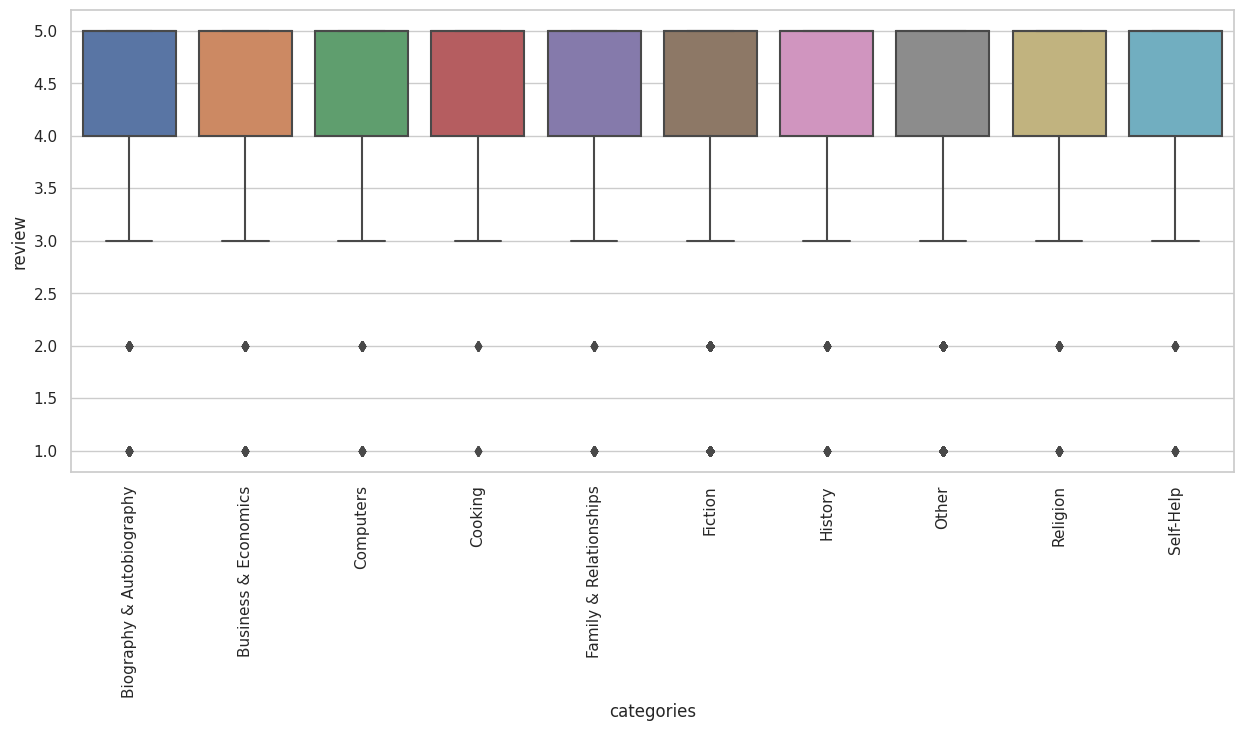

In [158]:
plt.figure(figsize=(15, 6))  # Set the figure size
sns.boxplot(x='categories', y='review', data=df_train)
plt.xticks(rotation=90)
plt.show()

In [159]:
df_train['categories'].unique()

['Other', 'Business & Economics', 'Fiction', 'Biography & Autobiography', 'Religion', 'Family & Relationships', 'Cooking', 'Computers', 'Self-Help', 'History']
Categories (10, object): ['Biography & Autobiography', 'Business & Economics', 'Computers', 'Cooking', ..., 'History', 'Other', 'Religion', 'Self-Help']

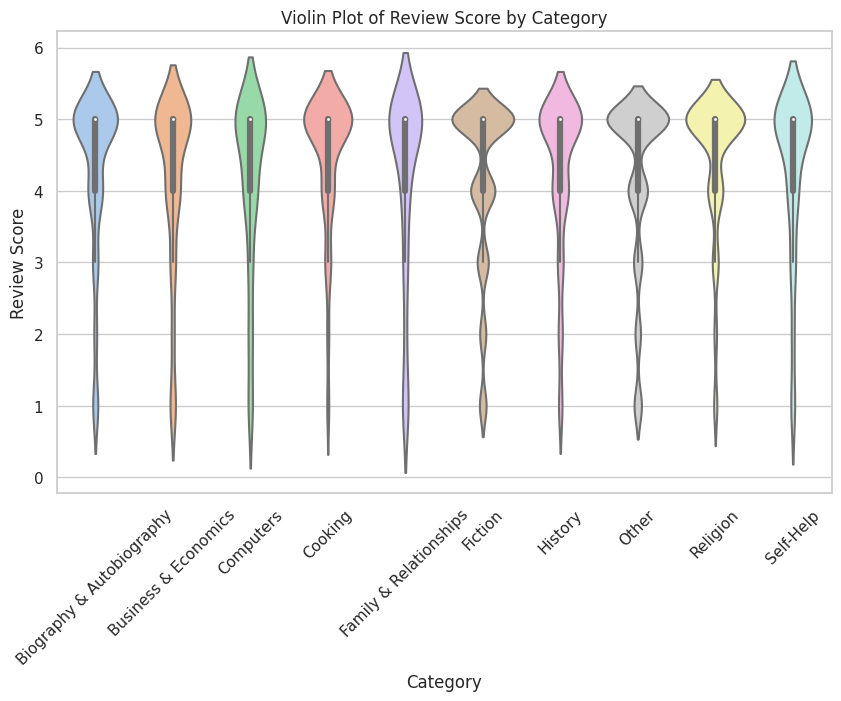

In [160]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='categories', y='review', data=df_train, palette='pastel')
plt.xlabel('Category')
plt.ylabel('Review Score')
plt.title('Violin Plot of Review Score by Category')
plt.xticks(rotation=45) 
plt.show()

### Key Findings for Categories:

- There are 10 different Categories in the Dataset.
- All of the reviewed categories contains reviews values in the 5 Categories [1, 2, 3, 4, 5]. All of the are biased to high review score.
- All categories but have lower quartile limit in Rating of 4 and minimum values of 3, but with outliers in 1 and 2 score reviews groups.
- 'Fiction' is most rated category. This category is biased to High review scores, having the mediana on 5. And the 25% quartile on 4.

## Published Year

In [161]:
pub_year = df_train[['published_year','review']]
pub_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11803 entries, 1226 to 14826
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   published_year  11803 non-null  int64  
 1   review          11803 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 276.6 KB


In [162]:
pub_year = pub_year.groupby('published_year')['review'].agg(['mean', 'count']).reset_index()
pub_year

published_year      mean  count
0            2004  4.148699   2152
1            2005  4.196481   2387
2            2006  4.053156   1505
3            2007  4.154392   1127
4            2008  4.240462    865
5            2009  4.264851   1212
6            2010  4.175538    883
7            2011  4.245902    610
8            2012  4.504301    930
9            2013  4.492424    132

In [163]:
pub_year['published_year'].describe().T

count      10.00000
mean     2008.50000
std         3.02765
min      2004.00000
25%      2006.25000
50%      2008.50000
75%      2010.75000
max      2013.00000
Name: published_year, dtype: float64

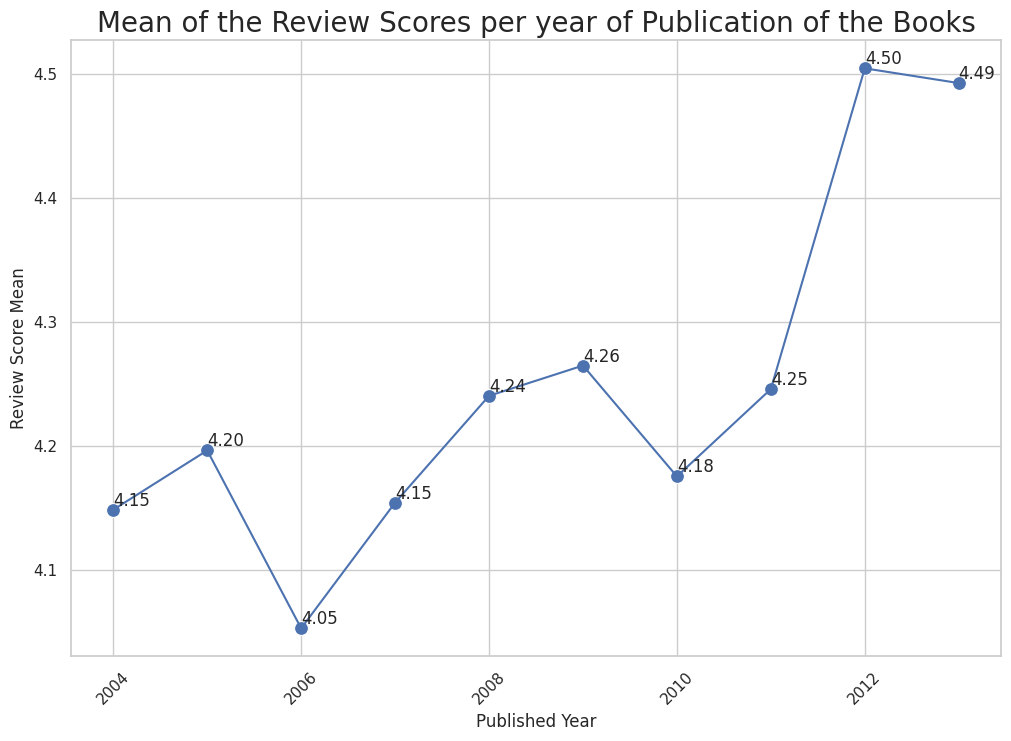

In [164]:
sns.set(style="whitegrid")  # Establecer el estilo de la cuadrícula
plt.figure(figsize=(12, 8))  # Establecer el tamaño de la figura

# Crear el gráfico de líneas con Seaborn
sns.lineplot(x=pub_year['published_year'], y=pub_year['mean'], linestyle='-')

sns.scatterplot(x=pub_year['published_year'], y=pub_year['mean'], color='b', s=100)

for i, row in pub_year.iterrows():
    plt.text(row['published_year'], row['mean'], f'{row["mean"]:.2f}', ha='left', va='bottom')

# Personalizar etiquetas y título
plt.xlabel('Published Year')
plt.ylabel('Review Score Mean')
plt.title('Mean of the Review Scores per year of Publication of the Books', fontsize=20)
plt.xticks(rotation=45)
# Mostrar el gráfico
plt.show()

In [165]:
df_train[(df_train['published_year']>=2004) & ((df_train['published_year']>=2010))]['categories'].value_counts()

categories
Fiction                      1432
Other                         684
Religion                      121
Biography & Autobiography     104
History                        73
Business & Economics           63
Family & Relationships         31
Cooking                        25
Self-Help                      18
Computers                       4
Name: count, dtype: int64

In [166]:
df_train[((df_train['published_year']>2010))]['categories'].value_counts()

categories
Fiction                      985
Other                        444
Religion                      68
History                       57
Biography & Autobiography     55
Business & Economics          20
Family & Relationships        20
Self-Help                     10
Cooking                        9
Computers                      4
Name: count, dtype: int64

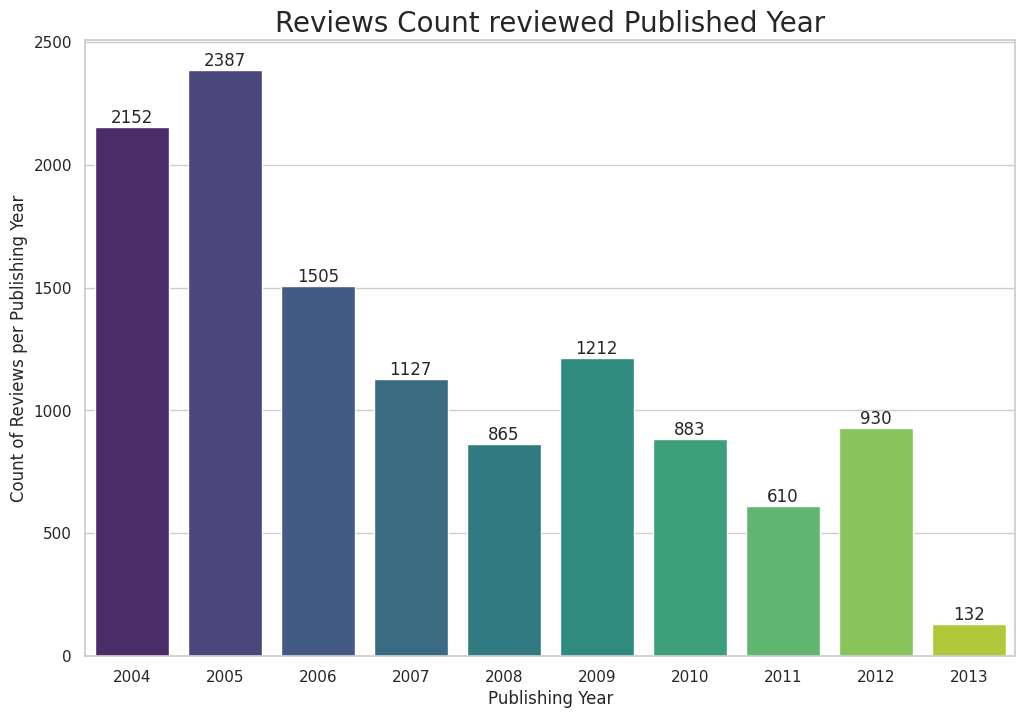

In [167]:

sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  

ax = sns.barplot(x=pub_year['published_year'], y=pub_year['count'], palette="viridis")

for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.title('Reviews Count reviewed Published Year', fontsize=20)
plt.ylabel('Count of Reviews per Publishing Year')
plt.xlabel('Publishing Year')

plt.show()

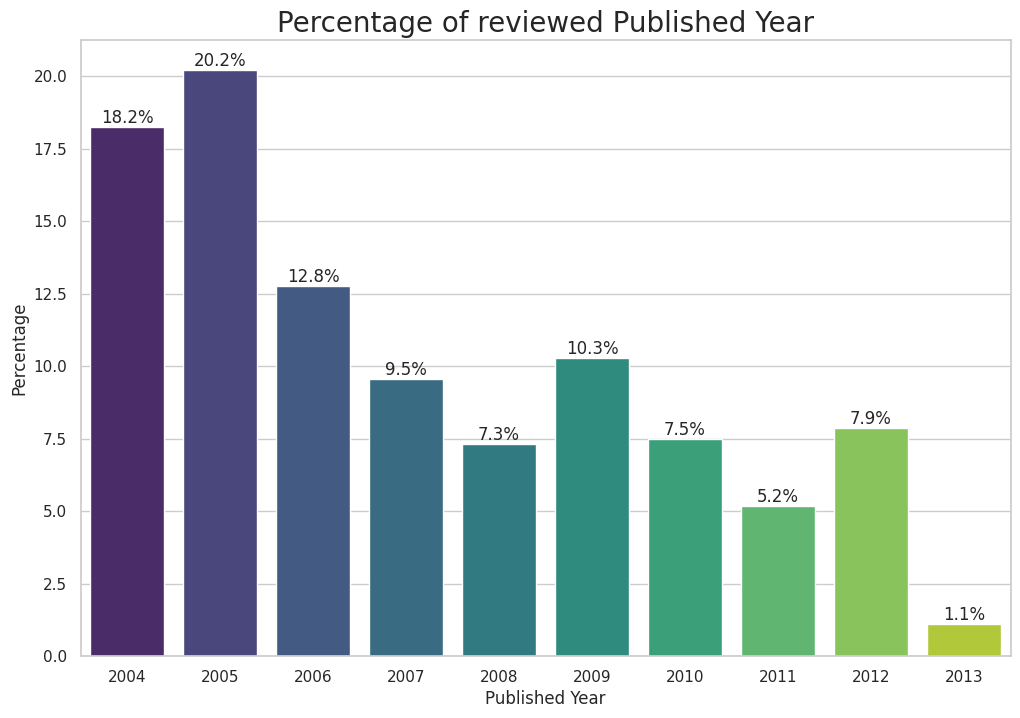

In [168]:
pub_year_percentage = (pub_year['count'] / pub_year['count'].sum()) * 100

sns.set(style="whitegrid")  # Establecer el estilo de la cuadrícula
plt.figure(figsize=(12, 8))  # Establecer el tamaño de la figura

# Crear el gráfico de barras con Seaborn
ax = sns.barplot(x=pub_year['published_year'], y=pub_year_percentage, palette="viridis")

# Agregar etiquetas de porcentaje en las barras
for bar, percentage in zip(ax.patches, pub_year_percentage):
    ax.annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# Personalizar etiquetas y título
plt.xlabel('Published Year')
plt.ylabel('Percentage')
plt.title('Percentage of reviewed Published Year', fontsize=20)

# Mostrar el gráfico
plt.show()

In [169]:
import plotly.express as px

fig = px.box(df_train, x='published_year', y='review')

# Personalizar el diseño del gráfico
fig.update_layout(
    title='Boxplot of Reviews by Published Year',
    title_x=0.5,
    xaxis_title='Published Year',
    yaxis_title='Review',
    xaxis=dict(
        tickangle=-45,        
    )
)

# Mostrar el gráfico interactivo
fig.show()

In [170]:
df_train[['published_year', 'review']].corr().style.background_gradient(cmap='Blues')

### Key Findings for Published Year

- All of the reviews for Published years, are biased to high scores. Having the quartile 25% above 4.
- Books published during the initial years of the dataset, namely 2004, 2005, and 2006, encompass 51.2% of the total dataset reviews. These years represent the period of highest activity.
- The average review score remains consistently between 4 and 4.5 across all the years of publication in the dataset


## Helpfulness

In [171]:
df_train.sample(2)

categories publisher  published_year  review_year  helpfulness  \
5777      Other     Other            2008         2009          1.0   
1737      Other     Other            2006         2012          1.0   

                                                                                                                                                 text_clean  \
5777                                                      fantastic resource teaching phonics word work give great idea whole group small group instruction   
1737  interesting entertaining book enjoyed really think shouldnt much violence book also time espicially didnt even want name nickname want back away n...   

      compound_sentiment  review  
5777              0.8271     5.0  
1737              0.9775     5.0

In [172]:
df_train['helpfulness'].describe().T

count    11803.000000
mean         0.821560
std          0.314801
min          0.000000
25%          0.750000
50%          1.000000
75%          1.000000
max          1.000000
Name: helpfulness, dtype: float64

In [173]:
#Create a box plot to check for outliers, median and quartiles
fig = px.box(df_train, y='helpfulness')

fig.update_xaxes(title_text='')
fig.update_layout(
    title='Boxplot for Helpfulness Feature',
    title_x=0.5        
)

fig.show()

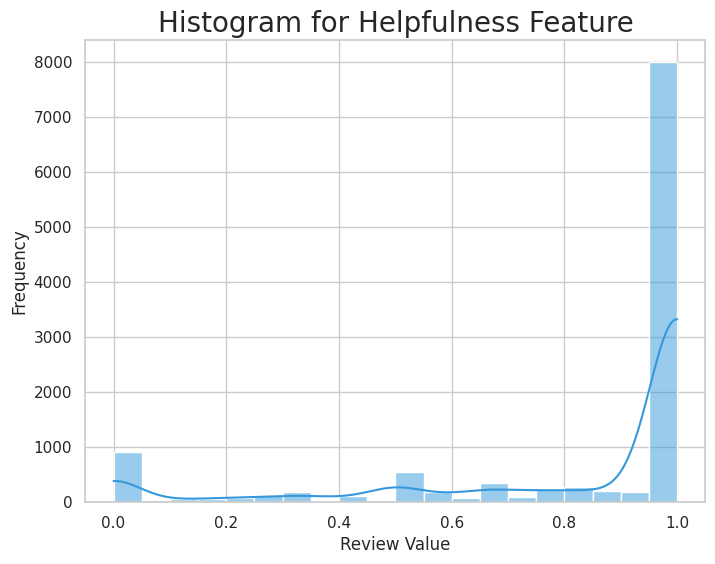

In [174]:
# df_train.hist(column='helpfulness')
# plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df_train['helpfulness'], bins=20, kde=True, color='#3498db')
plt.xlabel("Review Value")
plt.ylabel("Frequency")
plt.title("Histogram for Helpfulness Feature", fontsize=20)
plt.show()

In [175]:
#Correlation Analysis 
df_train[['helpfulness','review']].corr().style.background_gradient(cmap='Blues')

In [176]:

# Create an interactive box plot using Plotly
fig = px.box(df_train, x='review', y='helpfulness')

fig.update_layout(
    title='Box Plot of Review vs Helpfulness',
    xaxis_title='Review',
    yaxis_title='Helpfulness',
    title_x=0.5
)

# Show the interactive plot
fig.show()

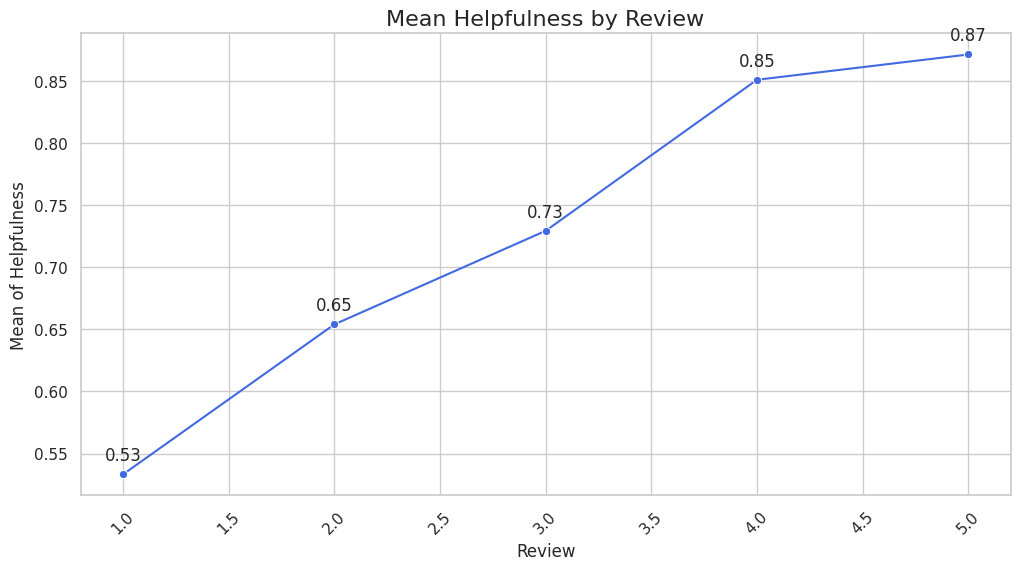

In [177]:
helpfulness_by_review = df_train.groupby('review')['helpfulness'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=helpfulness_by_review.index, y=helpfulness_by_review.values, marker='o', linestyle='-', color='royalblue')
plt.xlabel('Review')
plt.ylabel('Mean of Helpfulness')
plt.title('Mean Helpfulness by Review', fontsize=16)
plt.grid(True)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add labels to each point
for x, y in zip(helpfulness_by_review.index, helpfulness_by_review.values):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0,10), ha='center')

plt.show()

<Figure size 1200x600 with 0 Axes>

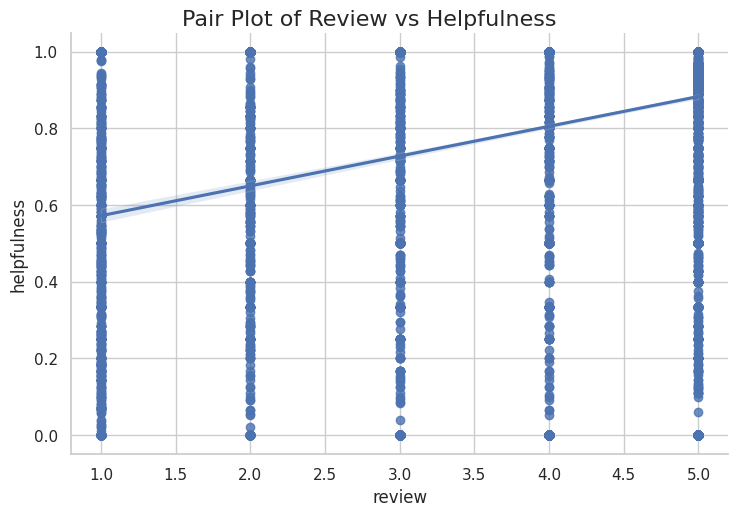

In [178]:
plt.figure(figsize=(12, 6))
sns.pairplot(df_train, x_vars=['review'], y_vars=['helpfulness'], kind='reg', height=5, aspect=1.5)
plt.suptitle('Pair Plot of Review vs Helpfulness', y=1.02, fontsize=16)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

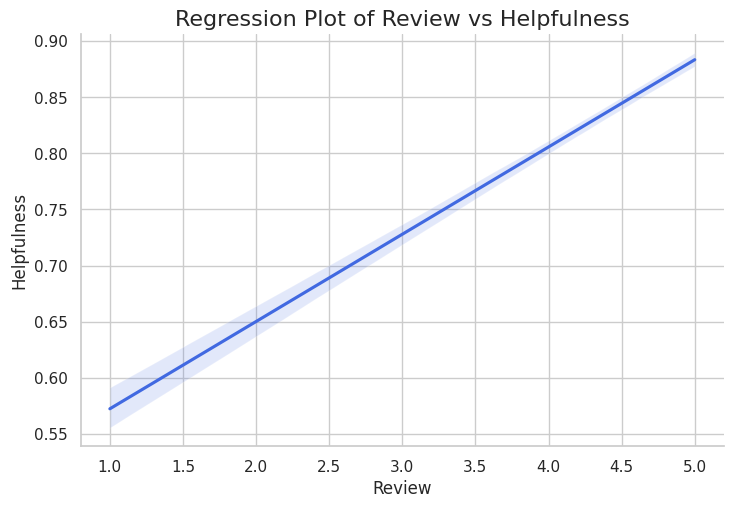

In [179]:
plt.figure(figsize=(12, 6))
sns.lmplot(x='review', y='helpfulness', data=df_train, height=5, aspect=1.5, scatter=False, line_kws={"color": "royalblue"})
plt.xlabel('Review')
plt.ylabel('Helpfulness')
plt.title('Regression Plot of Review vs Helpfulness', fontsize=16)
plt.grid(True)
plt.show()

### Key Findings for helpfulness

- Reviews with a high review score are found more helpfull than reviews with low review score.
- Mean of the helpfulness and review have a linear relationship.
- Helpfulness vs review regression plot confirms the linear relation between the variables.

## Review_Year

In [180]:
rev_year = df_train[['review_year','review']]
rev_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11803 entries, 1226 to 14826
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_year  11803 non-null  int64  
 1   review       11803 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 276.6 KB


In [181]:
rev_year = rev_year.groupby('review_year')['review'].agg(['mean', 'count']).reset_index()
rev_year

review_year      mean  count
0         2004  4.079681    502
1         2005  4.147203   1019
2         2006  4.071033   1084
3         2007  4.180804    896
4         2008  4.078283    792
5         2009  4.102345    938
6         2010  4.138734   1074
7         2011  4.148515   1313
8         2012  4.300729   2607
9         2013  4.441065   1578

In [182]:
rev_year['review_year'].describe().T

count      10.00000
mean     2008.50000
std         3.02765
min      2004.00000
25%      2006.25000
50%      2008.50000
75%      2010.75000
max      2013.00000
Name: review_year, dtype: float64

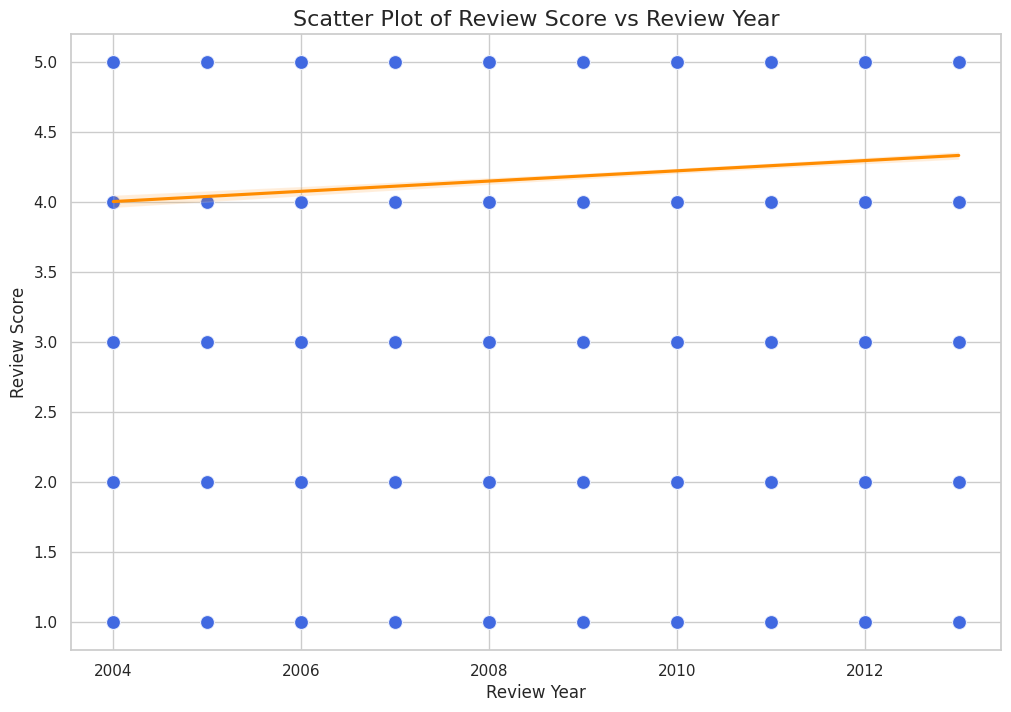

In [183]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='review_year', y='review', data=df_all_data_processed, color='royalblue', alpha=0.7, edgecolor='w', s=100)
sns.regplot(x='review_year', y='review', data=df_all_data_processed, scatter=False, color='darkorange')
plt.xlabel('Review Year')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Review Score vs Review Year', fontsize=16)
plt.grid(True)
plt.show()

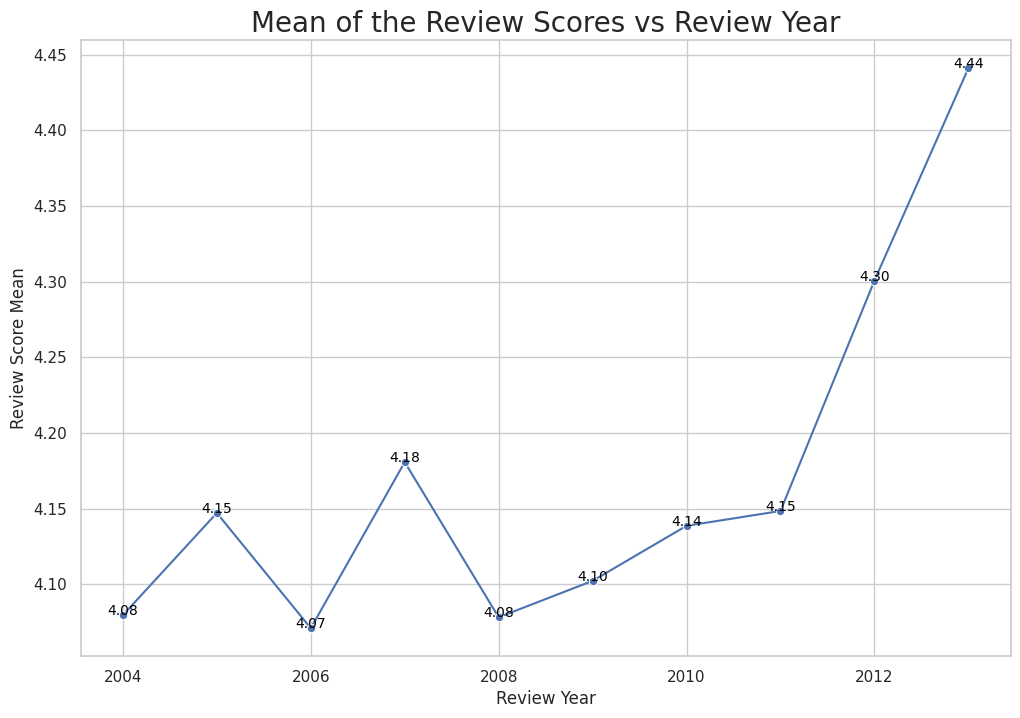

In [184]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=rev_year, x='review_year', y='mean', marker='o', linestyle='-')
plt.xlabel('Review Year')
plt.ylabel('Review Score Mean')
plt.title('Mean of the Review Scores vs Review Year', fontsize=20)
plt.grid(True)

# Add labels to the points
for line in range(0, rev_year.shape[0]):
    ax.text(rev_year['review_year'][line], rev_year['mean'][line], f'{rev_year["mean"][line]:.2f}', horizontalalignment='center', fontsize=10, color='black')

plt.show()

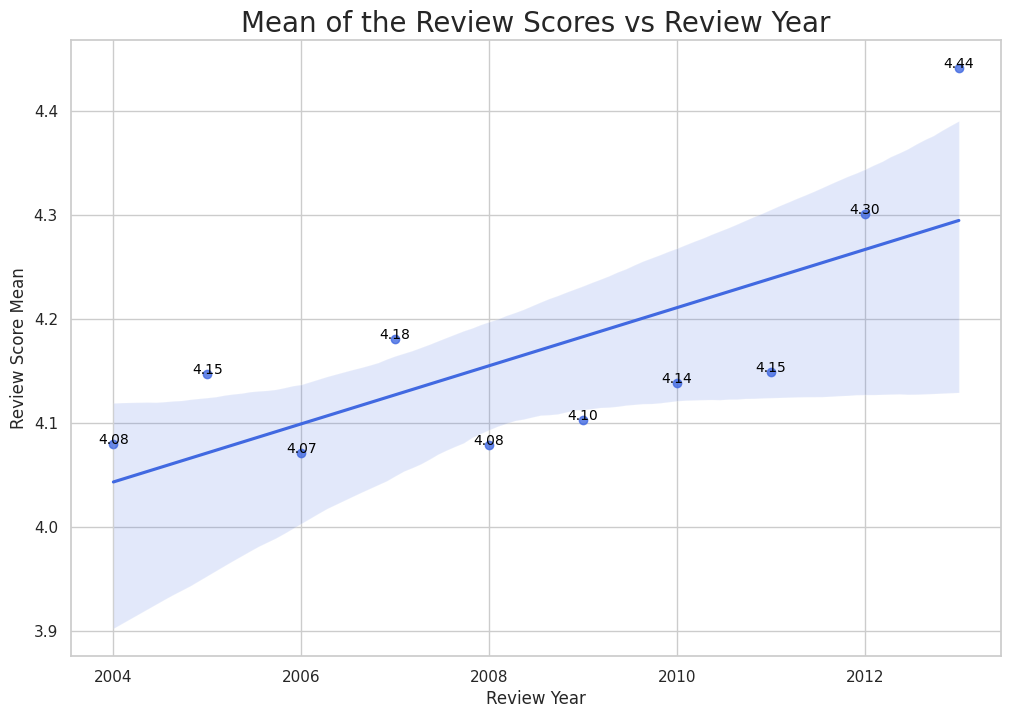

In [185]:
plt.figure(figsize=(12, 8))
ax = sns.regplot(data=rev_year, x='review_year', y='mean', color='royalblue')
plt.xlabel('Review Year')
plt.ylabel('Review Score Mean')
plt.title('Mean of the Review Scores vs Review Year', fontsize=20)
plt.grid(True)

# Add labels to the points
for line in range(0, rev_year.shape[0]):
    ax.text(rev_year['review_year'][line], rev_year['mean'][line], f'{rev_year["mean"][line]:.2f}', horizontalalignment='center', fontsize=10, color='black')

plt.show()

In [186]:
df_train[['review_year', 'review']].corr().style.background_gradient(cmap='Blues')

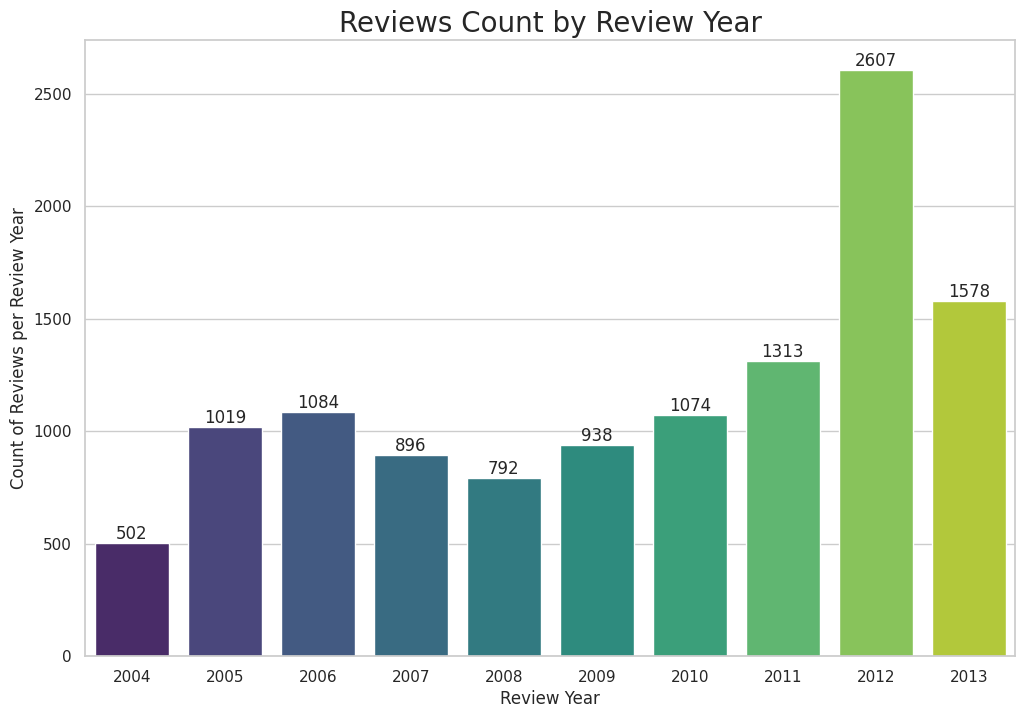

In [187]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  

ax = sns.barplot(x=rev_year['review_year'], y=rev_year['count'], palette="viridis")

for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.title('Reviews Count by Review Year', fontsize=20)
plt.ylabel('Count of Reviews per Review Year')
plt.xlabel('Review Year')

plt.show()

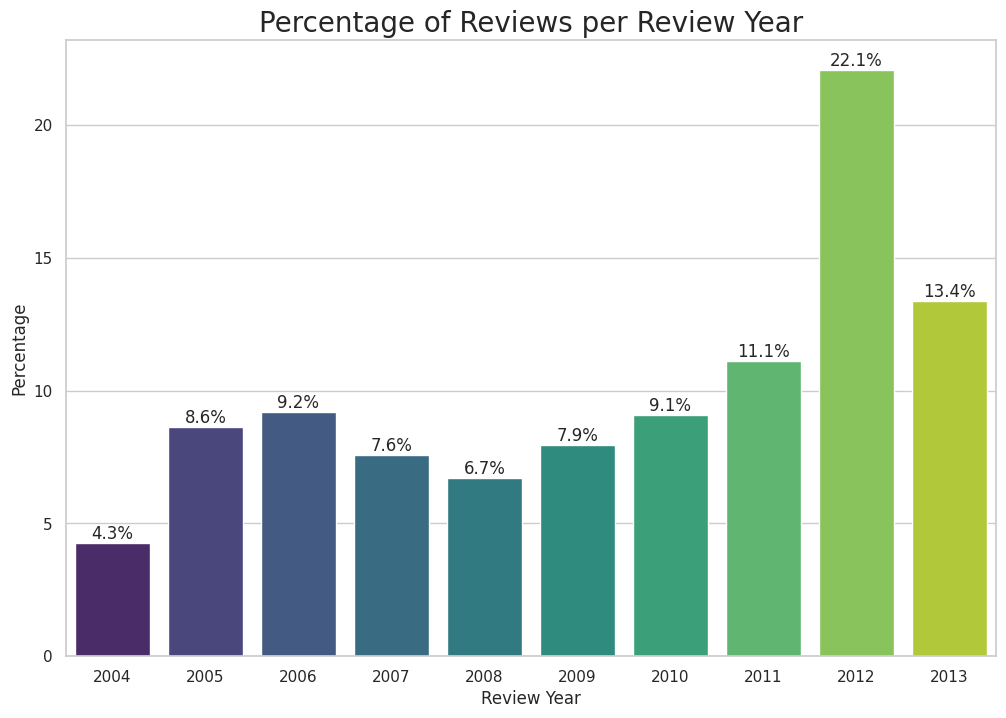

In [188]:
rev_year_percentage = (rev_year['count'] / rev_year['count'].sum()) * 100

sns.set(style="whitegrid")  # Establecer el estilo de la cuadrícula
plt.figure(figsize=(12, 8))  # Establecer el tamaño de la figura

# Crear el gráfico de barras con Seaborn
ax = sns.barplot(x=rev_year['review_year'], y=rev_year_percentage, palette="viridis")

# Agregar etiquetas de porcentaje en las barras
for bar, percentage in zip(ax.patches, rev_year_percentage):
    ax.annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# Personalizar etiquetas y título
plt.xlabel('Review Year')
plt.ylabel('Percentage')
plt.title('Percentage of Reviews per Review Year', fontsize=20)

# Mostrar el gráfico
plt.show()

In [189]:
fig = px.box(df_train, x='review_year', y='review')

# Personalizar el diseño del gráfico
fig.update_layout(
    title='Boxplot of Review Score by Review Year',
    title_x=0.5,
    xaxis_title='Review Year',
    yaxis_title='Review',
    xaxis=dict(
        tickangle=-45,        
    )
)

# Mostrar el gráfico interactivo
fig.show()

### Key Findings for Review Year
- The years with the highest volume of reviews for Amazon Books are 2011, 2012, and 2013.
- The review scores for all years tend to skew towards higher ratings, with the 25th percentile (Q1) above 4 and the median at 5. The only exception is in 2008, where the 25th percentile (Q1) is at 3.

## Publisher

In [190]:
df_train.sample(2)

categories publisher  published_year  review_year  helpfulness  \
9031    Fiction     Other            2009         2011          0.5   
9814      Other     Other            2013         2013          1.0   

                                                                                                                                                 text_clean  \
9031  glad read book doubt could recommend glad read suffering sudan persisted long sure better book criticism think voice author couple reason time see...   
9814                                                                                bought book girlfriend helped become better writer essay project school   

      compound_sentiment  review  
9031             -0.9652     3.0  
9814              0.4404     5.0

In [191]:
print(f'Total of Publishers: {len(df_train["publisher"].unique())}')

Total of Publishers: 10


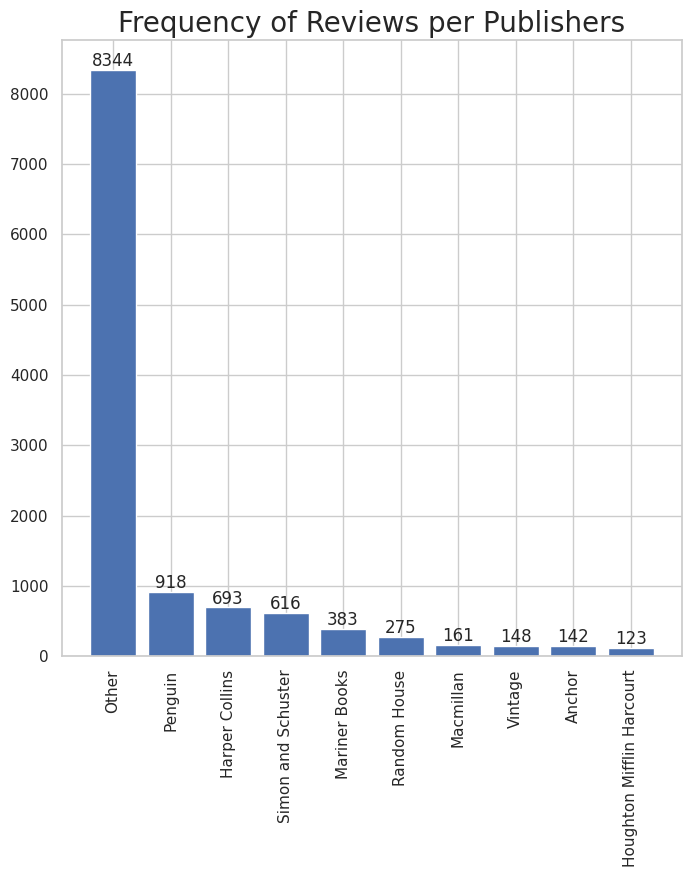

In [192]:
fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['publisher'].value_counts(ascending = False).keys(), df_train['publisher'].value_counts(ascending = False))
# Set the bar labels (percentages) to be displayed above the bars
ax.bar_label(bars)
plt.title('Frequency of Reviews per Publishers', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

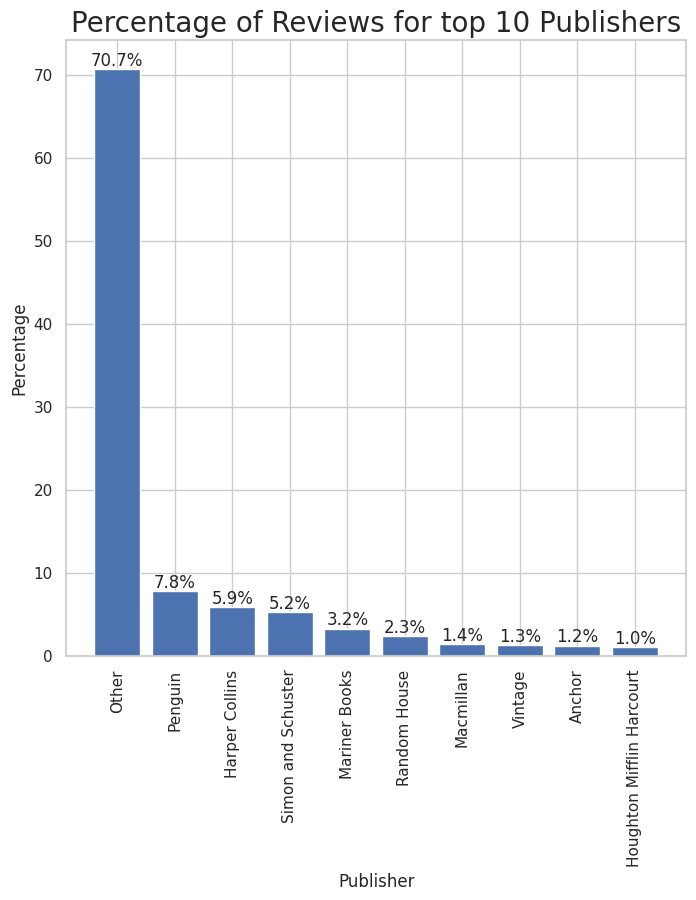

In [193]:
#Show a barplot by Percentages
author_percetage = df_train['publisher'].value_counts(ascending = False)/df_train['publisher'].value_counts(ascending = False).sum()*100

fig, ax = plt.subplots(figsize=(8, 8))
bars = ax.bar(df_train['publisher'].value_counts(ascending = False).keys(), author_percetage)

# Set the bar labels (percentages) to be displayed above the bars
ax.bar_label(bars, fmt='%.1f%%')

plt.xlabel('Publisher')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Percentage of Reviews for top 10 Publishers', fontsize = 20)
plt.show()


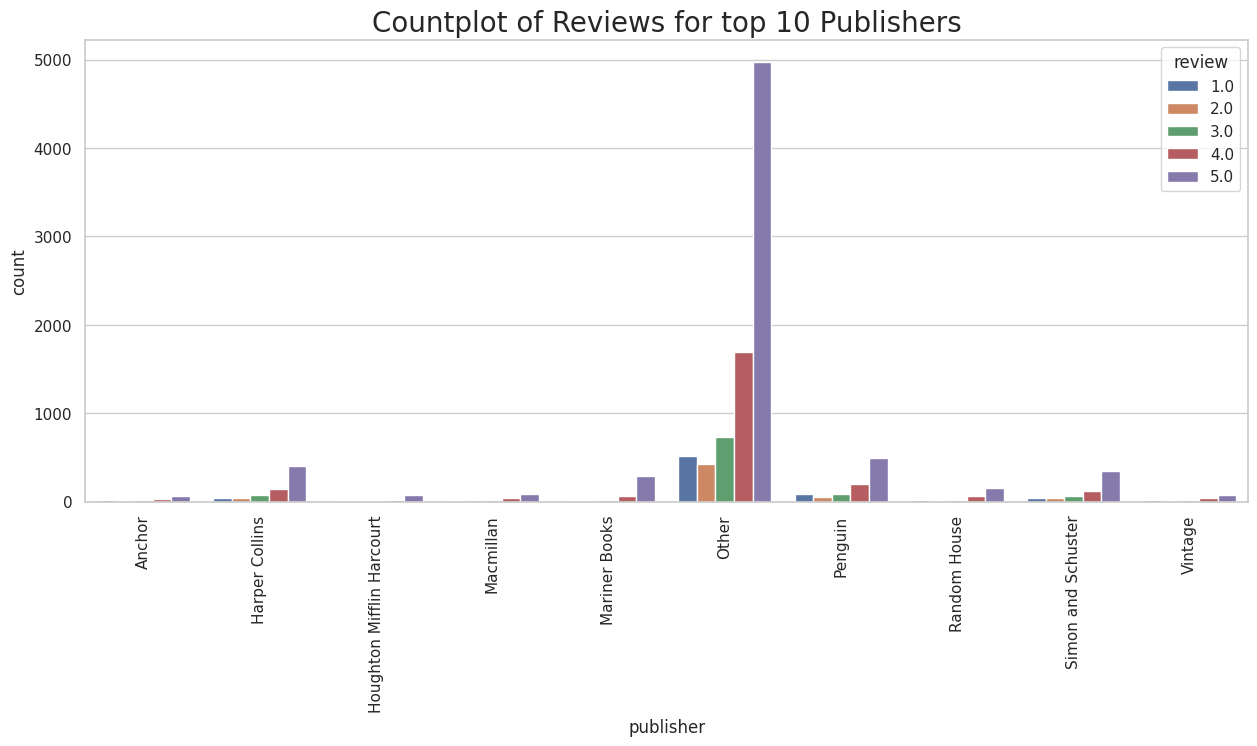

In [194]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df_train, x = 'publisher', hue='review')
plt.title('Countplot of Reviews for top 10 Publishers', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

In [195]:
fig = px.box(df_train, x='publisher', y='review')
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(
    title='Interactive Box Plot of Review by Publisher',
    xaxis_title='Publisher',
    yaxis_title='Review'
)
fig.show()

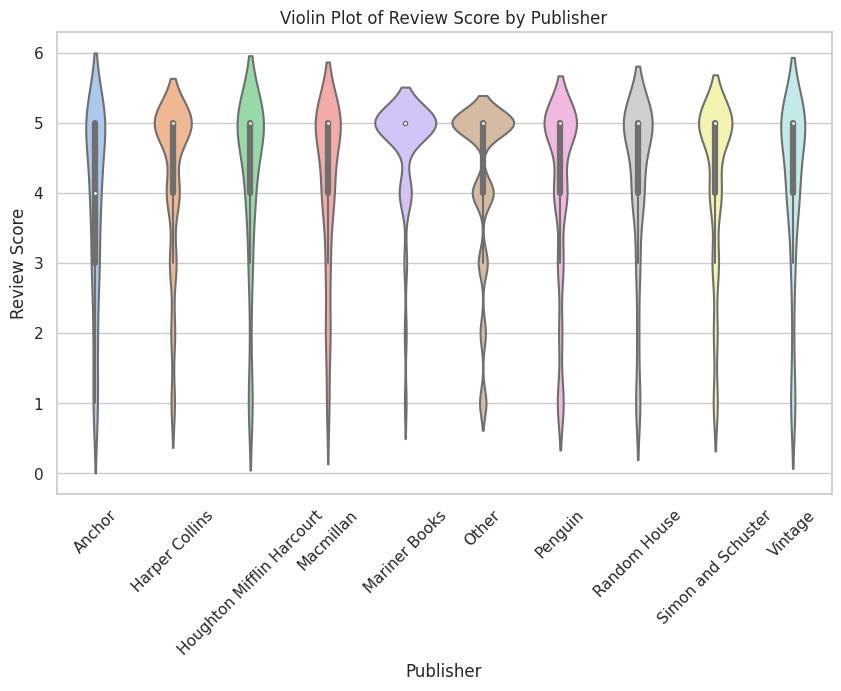

In [196]:

plt.figure(figsize=(10, 6))
sns.violinplot(x='publisher', y='review', data=df_train, palette='pastel')
plt.xlabel('Publisher')
plt.ylabel('Review Score')
plt.title('Violin Plot of Review Score by Publisher')
plt.xticks(rotation=45) 
plt.show()


### Key Findings for Publisher

- All of the Top Publishers have a Review Score biased to high values. All of them but Macmillan have the 25% percentile above 4. Having the median value and 75% percentile on 5. 
- All of the Publishers have values on the 5 possible review scores. As it contains valid variability, this feature is kept.

## Compound Sentiment

This variable is the result of applying vader lexicon with NLTK library to the cleaned text review from the Dataset.

In [197]:
df_train.sample(2)

categories publisher  published_year  review_year  helpfulness  \
14342    Fiction     Other            2011         2011          1.0   
12469      Other     Other            2006         2012          1.0   

                                                                                                                                                  text_clean  \
14342                   special book great story remember loving child love sweet bull interest fighting despite named prestigious bullfight spain fantastic   
12469  best writer fishing living today incredibly well rounded book delight read book sport commentary giving play play fish caught rather investigation...   

       compound_sentiment  review  
14342              0.9719     5.0  
12469              0.9690     5.0

In [198]:
df_train['compound_sentiment'].describe().T

count    11803.000000
mean         0.640197
std          0.491948
min         -0.996700
25%          0.571900
50%          0.855500
75%          0.952100
max          0.999900
Name: compound_sentiment, dtype: float64

compound_sentiment range goes from -1 to 1. As more near is the value to 1, more positive is the sentiment extracted from the text. And as more near to -1 is the value,
more negative is the sentiment predicted from the value.

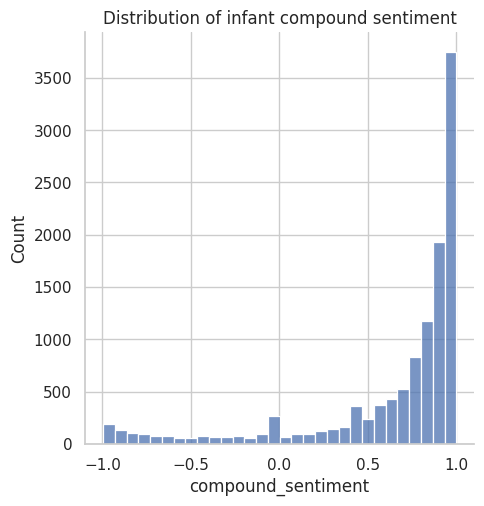

In [199]:
sns.displot(df_train['compound_sentiment'], bins=30)

plt.title('Distribution of infant compound sentiment')

plt.show()

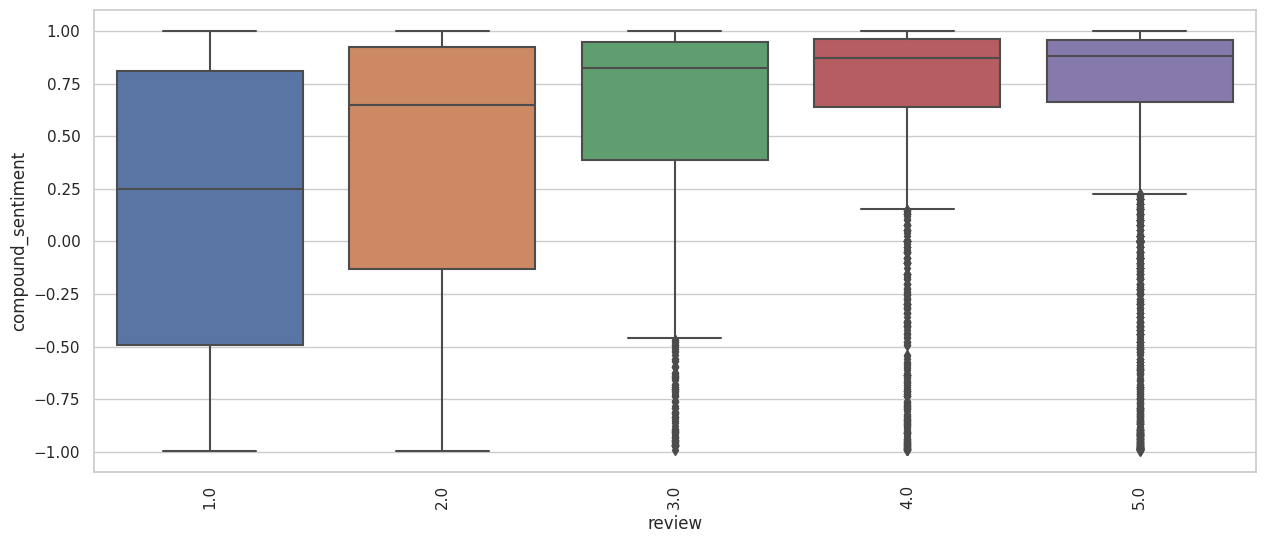

In [200]:
plt.figure(figsize=(15, 6)) 
sns.boxplot(x='review', y='compound_sentiment', data=df_train)
plt.xticks(rotation=90)
plt.show()

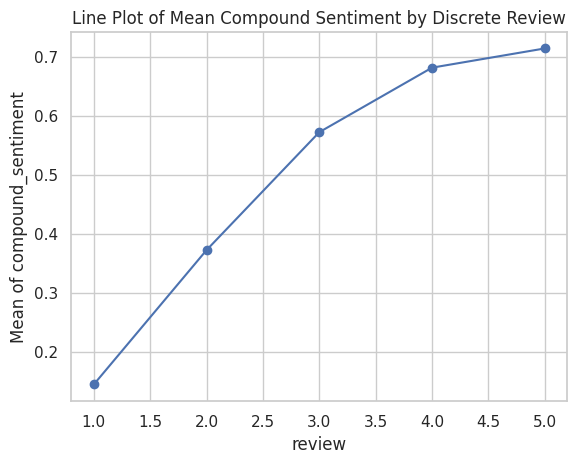

In [201]:
mean_by_review = df_train.groupby('review')['compound_sentiment'].mean()
mean_by_review.plot(kind='line', marker='o', linestyle='-')
plt.xlabel('review')
plt.ylabel('Mean of compound_sentiment')
plt.title('Line Plot of Mean Compound Sentiment by Discrete Review')
plt.grid(True)
plt.show()

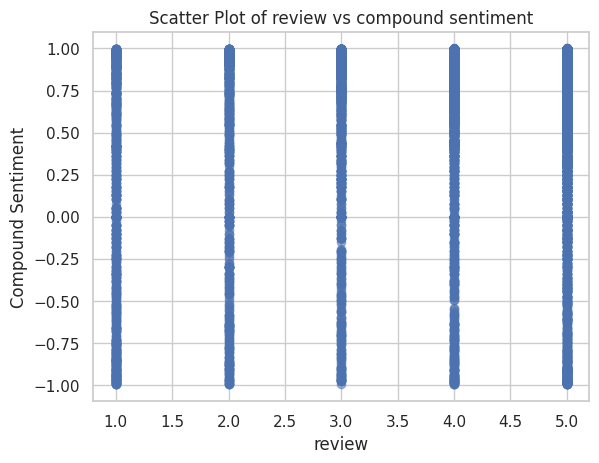

In [202]:
plt.scatter(df_train['review'], df_train['compound_sentiment'], alpha=0.5)
plt.xlabel('review')
plt.ylabel('Compound Sentiment')
plt.title('Scatter Plot of review vs compound sentiment')
plt.show()

In [203]:
df_train[['compound_sentiment', 'review']].corr().style.background_gradient(cmap='Blues')

### Key Findings for Compound Sentiment

- From the Distribution Plot, it is visible that Compound Sentiment Feature is biased to high levels/positive levels.
- The Boxplot figure shows the relation between review and compound sentiment. For High score reviews, the Compound sentiments tends to increase and be positive. And for Low Review Scores, the sentiment tends to be negative. This can explain the first bullet, because the dataset contains more entries with High Score Values, the positive Compound sentiment will increse.
- The line plot confirms the relationship between review and compound sentiment, plotting the mean of the compound sentiment for each review score. There is a positive relation. When review tends to be high, compound sentiment tends to be 1. 

## EDA for Review Text Column

In [204]:
pd.set_option('display.max_colwidth', 150)

In [205]:
df_train[df_train['review']==5]['text_clean'].sample(5, random_state=1299)

414      receiving status book great condition order delivered time reading comment official guide great helpful prepare gmat test model exam practical exe...
105                  really enjoy seires book janette great writer want contuniue read juat next series call heart canadian west break dawn canadian west book
15542    girlfriend recommended take class together likely would ever read book glad easiest read year mainly reading contemporary literature took brain mi...
5126                                                                                             beverly lewis another wonderful series make sure order hooked
2252                                                          great book opening must read student high school college adult recommend whole uncle eric series
Name: text_clean, dtype: object

Word Cloud of most repeated 100 words on reviews with a review Score = 5. 


In [206]:
#FIXME Extraer texto por tipo de categoria

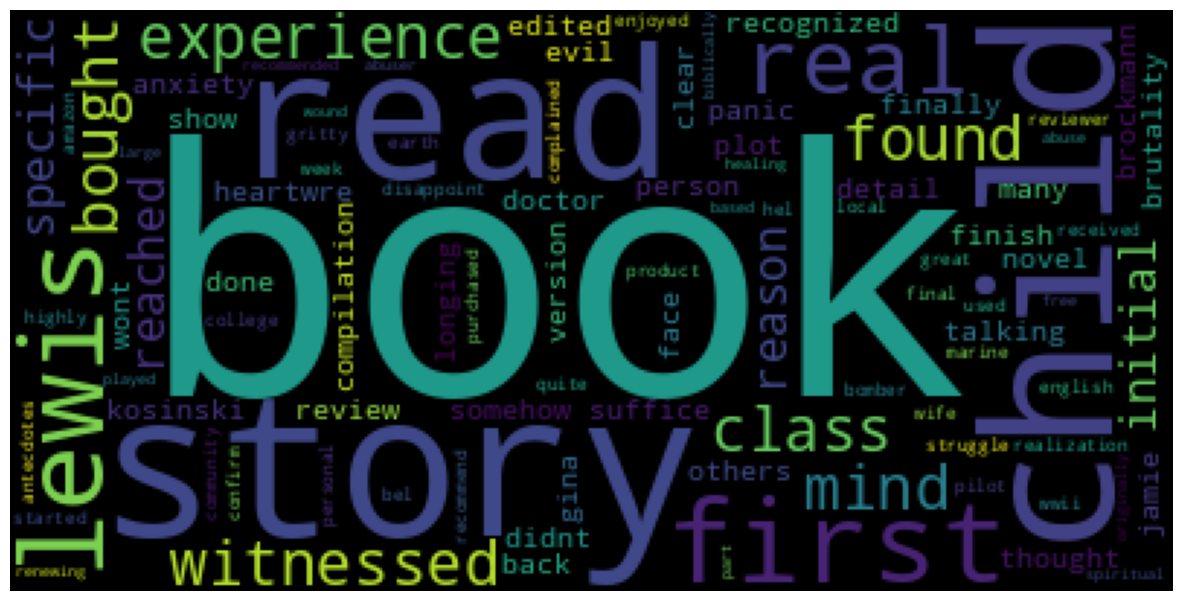

In [207]:
wordcloud5 = WordCloud(max_words=100).generate(str(df_train[df_train['review']==5]['text_clean']))

fig = plt.figure(figsize=(15,12))

plt.axis('off')

plt.imshow(wordcloud5)

plt.show()

In [208]:
df_train[df_train['review']==1]['text_clean'].sample(5, random_state=1299)

14899    unclear everyone raving book found skipping paragraph dismayed cliche copy actually used avoided like plague character seemingly content woman fin...
12969    silent prey hallmark space filler book designed meet contractual obligation poorly paced away place make prey series unique hard clever york crew ...
6629                 common sense information basically book provides give helpful information instead telling refer state differ state state waste time money
12965    robert heinlein well know science fiction writer assumed tunnel would fairly well written wrong premise book interesting however character dialogu...
2820                                                           bought book think latest edition edition obviously although printed amazon specify edition book
Name: text_clean, dtype: object

In [209]:
df_train[df_train['review']==3]['text_clean'].sample(5, random_state=1299)

11957                                                       link table content chapter order read book fine good read still pain neck keep order book together
9272     despite publicity memoir people later determined truthful genre still flourishing recently reviewed right story four welch sibling left orphaned f...
5851     first chapter schniedewind book bible became book present main question later went detail throughout book always controversy actually wrote bible ...
5468     read many susan book enjoyed would enjoy character moralistic free favor loved book portrayed heroine much backbone realising potential loved plot...
2390     wanting read book long time finally interested subject followed story closely news time week half time many shooting mother road trip rhode island...
Name: text_clean, dtype: object

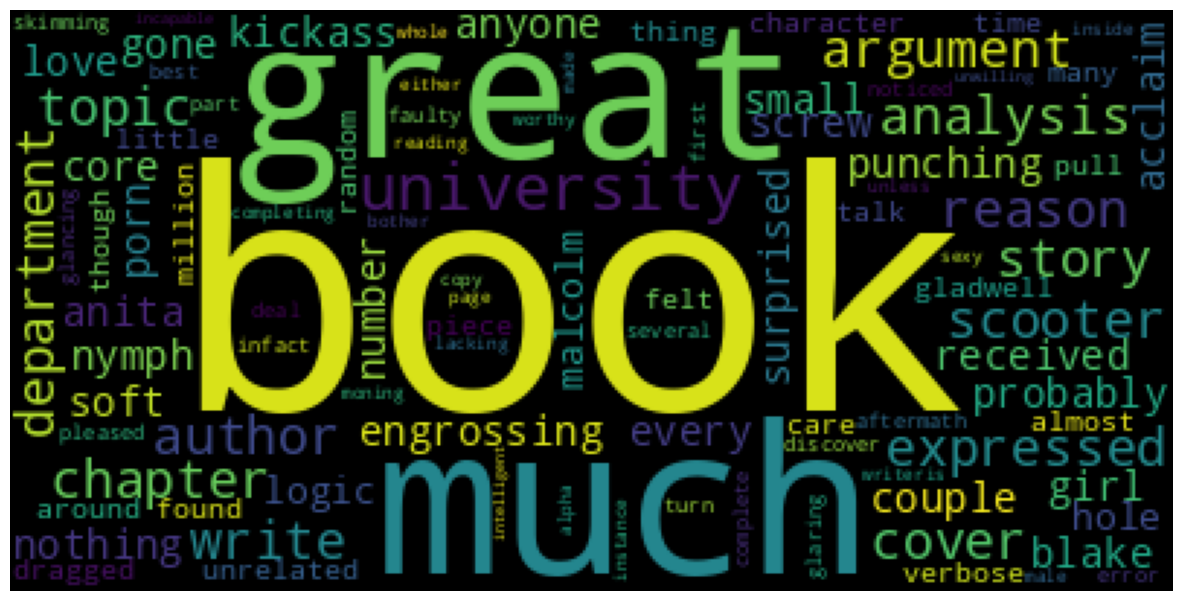

In [210]:
wordcloud1 = WordCloud(max_words=100).generate(str(df_train[df_train['review']==1]['text_clean']))

fig = plt.figure(figsize=(15,12))

plt.axis('off')

plt.imshow(wordcloud1)

plt.show()

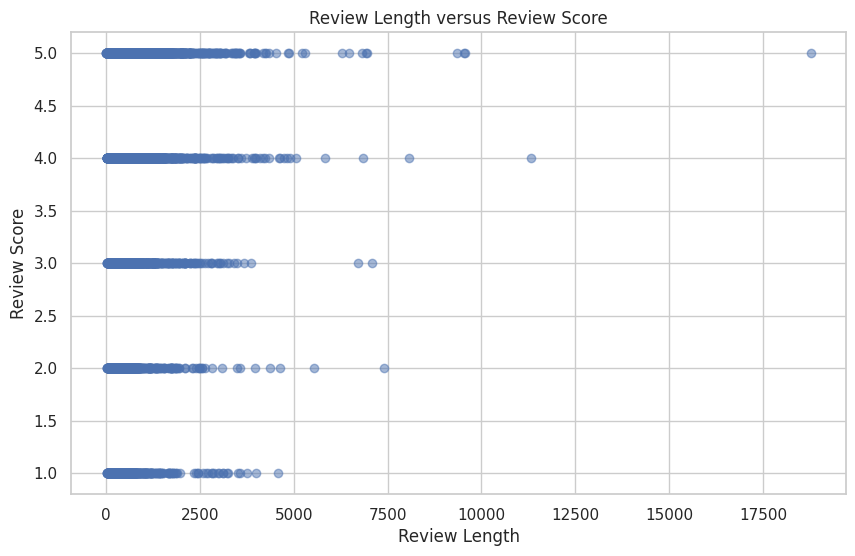

In [211]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['text_clean'].str.len(), df_train['review'], alpha=0.5)
plt.title('Review Length versus Review Score')
plt.xlabel('Review Length')
plt.ylabel('Review Score')
plt.show()

In [212]:
df_train['text_clean'].str.len().mean()

453.9401846988054

In [213]:
df_train['text_clean'].str.len().std()

637.5010341389645

In [214]:
long_reviews = df_train[df_train['text_clean'].str.len() > 2000].copy()

len(long_reviews)

318

In [215]:
long_reviews.describe().T

count         mean       std        min          25%  \
published_year      318.0  2006.490566  2.440117  2004.0000  2004.000000   
review_year         318.0  2008.566038  2.789182  2004.0000  2006.000000   
helpfulness         318.0     0.793205  0.293859     0.0000     0.666667   
compound_sentiment  318.0     0.638434  0.691342    -0.9967     0.896975   
review              318.0     4.031447  1.209434     1.0000     3.000000   

                            50%          75%        max  
published_year      2006.000000  2008.000000  2013.0000  
review_year         2009.000000  2011.000000  2013.0000  
helpfulness            0.962153     1.000000     1.0000  
compound_sentiment     0.987150     0.996875     0.9999  
review                 4.000000     5.000000     5.0000

In [216]:
long_reviews['text_clean'].str.len().mean()

3097.7955974842766

In [217]:
short_reviews = df_train[df_train['text_clean'].str.len() < 200].copy()

len(short_reviews)

5220

In [218]:
short_reviews['text_clean'].str.len().mean()

110.07547892720306

In [219]:
short_reviews.describe().T

count         mean       std        min          25%  \
published_year      5220.0  2007.718774  2.774986  2004.0000  2005.000000   
review_year         5220.0  2010.468199  2.560617  2004.0000  2009.000000   
helpfulness         5220.0     0.815607  0.346155     0.0000     0.833333   
compound_sentiment  5220.0     0.613577  0.388031    -0.9565     0.476700   
review              5220.0     4.338889  1.120068     1.0000     4.000000   

                         50%       75%       max  
published_year      2007.000  2010.000  2013.000  
review_year         2012.000  2012.000  2013.000  
helpfulness            1.000     1.000     1.000  
compound_sentiment     0.765     0.886     0.992  
review                 5.000     5.000     5.000

In [220]:
high_reviews = df_train[df_train['review'] == 5].copy()

high_reviews['text_clean'].str.len().mean()

400.9380200860832

In [221]:
neutral_reviews = df_train[df_train['review'] == 3].copy() # Neutral ratings tend to be larger in words count

neutral_reviews['text_clean'].str.len().mean()

555.6996197718631

In [222]:
low_reviews = df_train[df_train['review'] == 1].copy()

low_reviews['text_clean'].str.len().mean()

477.73850197109067

<Figure size 1000x600 with 0 Axes>

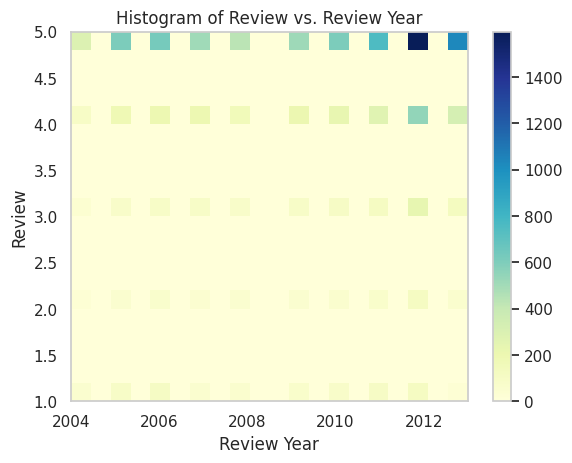

In [223]:
# Create a figure and a set background color
fig = plt.figure(figsize=(10, 6))
plt.figure()
plt.hist2d(df_train['review_year'], df_train['review'], bins=(20, 20), cmap=plt.cm.YlGnBu)
plt.colorbar()
plt.title('Histogram of Review vs. Review Year')
plt.xlabel('Review Year')
plt.ylabel('Review')
plt.show()

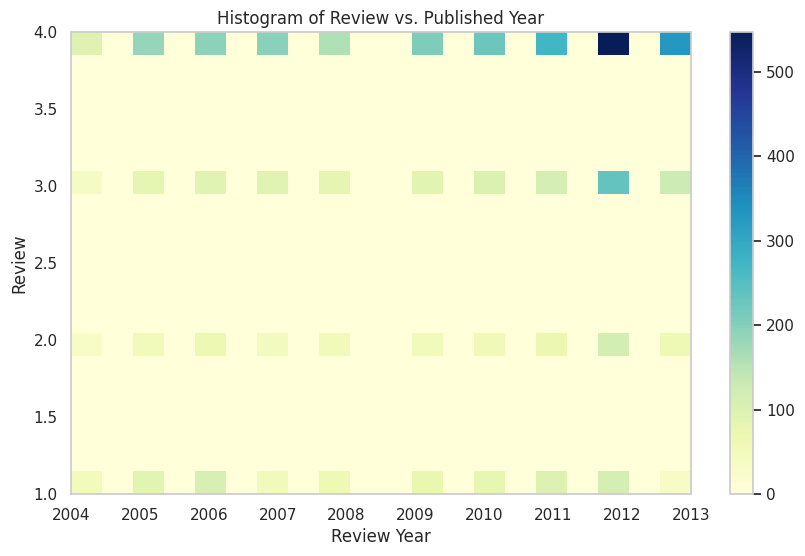

In [224]:
plt.figure(figsize=(10, 6))
plt.hist2d(df_train[df_train['review'] != 5]['review_year'], df_train[df_train['review'] != 5]['review'], bins=(20, 20), cmap=plt.cm.YlGnBu)
plt.colorbar()
plt.title('Histogram of Review vs. Published Year')
plt.xlabel('Review Year')
plt.ylabel('Review')
plt.show()

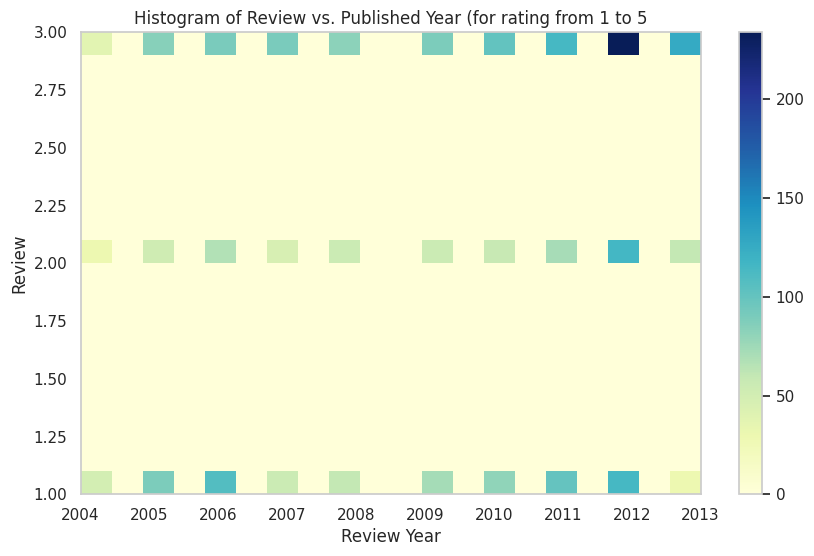

In [225]:
plt.figure(figsize=(10, 6))
plt.hist2d(df_train[(df_train['review'] != 4) & (df_train['review'] != 5)]['review_year'], df_train[(df_train['review'] != 4) & (df_train['review'] != 5)]['review'], bins=(20, 20), cmap=plt.cm.YlGnBu)
plt.colorbar()
plt.title('Histogram of Review vs. Published Year (for rating from 1 to 5')
plt.xlabel('Review Year')
plt.ylabel('Review')
plt.show()

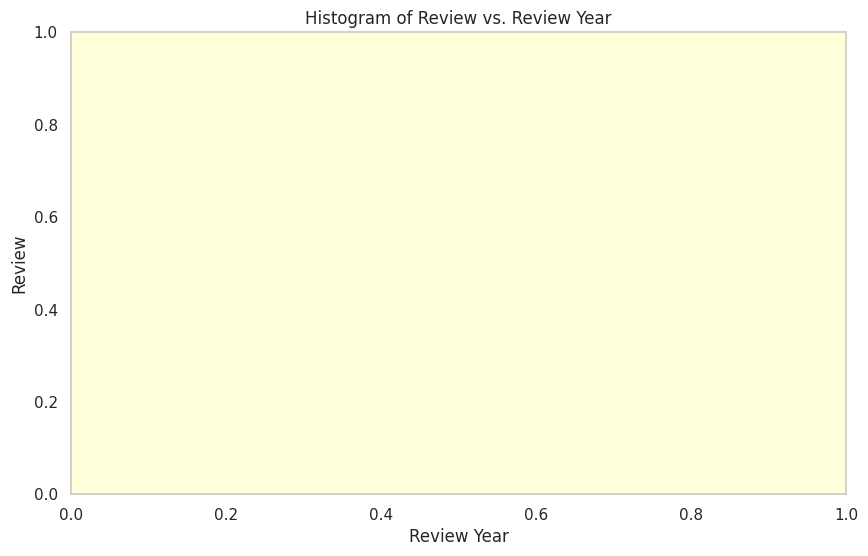

In [226]:
plt.figure(figsize=(10, 6))
plt.hist2d(df_train[df_train['review_year'] <= 2000]['review_year'], df_train[df_train['review_year'] <= 2000]['review'], bins=(20, 20), cmap=plt.cm.YlGnBu)
plt.title('Histogram of Review vs. Review Year')
plt.xlabel('Review Year')
plt.ylabel('Review')
plt.show()

# Multivariable Analysis

In [227]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11803 entries, 1226 to 14826
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   categories          11803 non-null  category
 1   publisher           11803 non-null  category
 2   published_year      11803 non-null  int64   
 3   review_year         11803 non-null  int64   
 4   helpfulness         11803 non-null  float64 
 5   text_clean          11803 non-null  object  
 6   compound_sentiment  11803 non-null  float64 
 7   review              11803 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(1)
memory usage: 669.3+ KB


In [228]:
df_train.select_dtypes('number').corr().style.background_gradient(cmap='Blues')

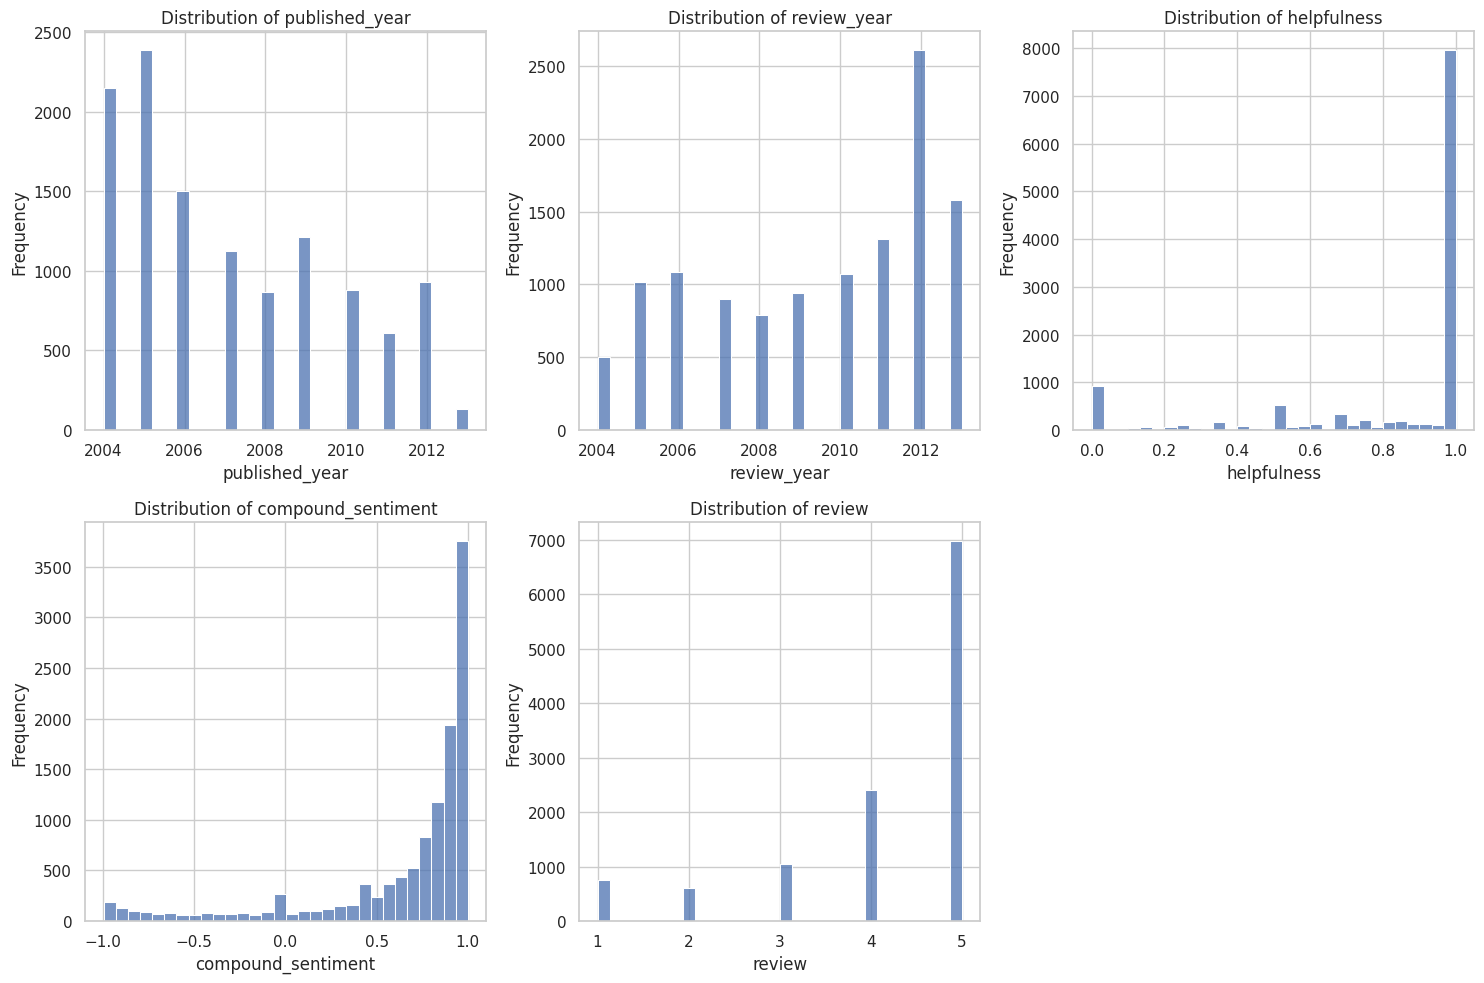

In [229]:


#Histogram with SNS

numerical_features = df_train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features)//3 + 1, 3, i)
    sns.histplot(df_train[feature], kde=False, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

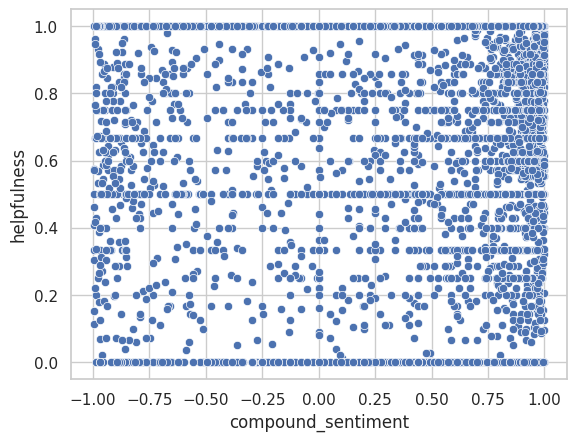

In [230]:
sns.scatterplot(data=df_train, x= 'compound_sentiment', y='helpfulness')
plt.show()

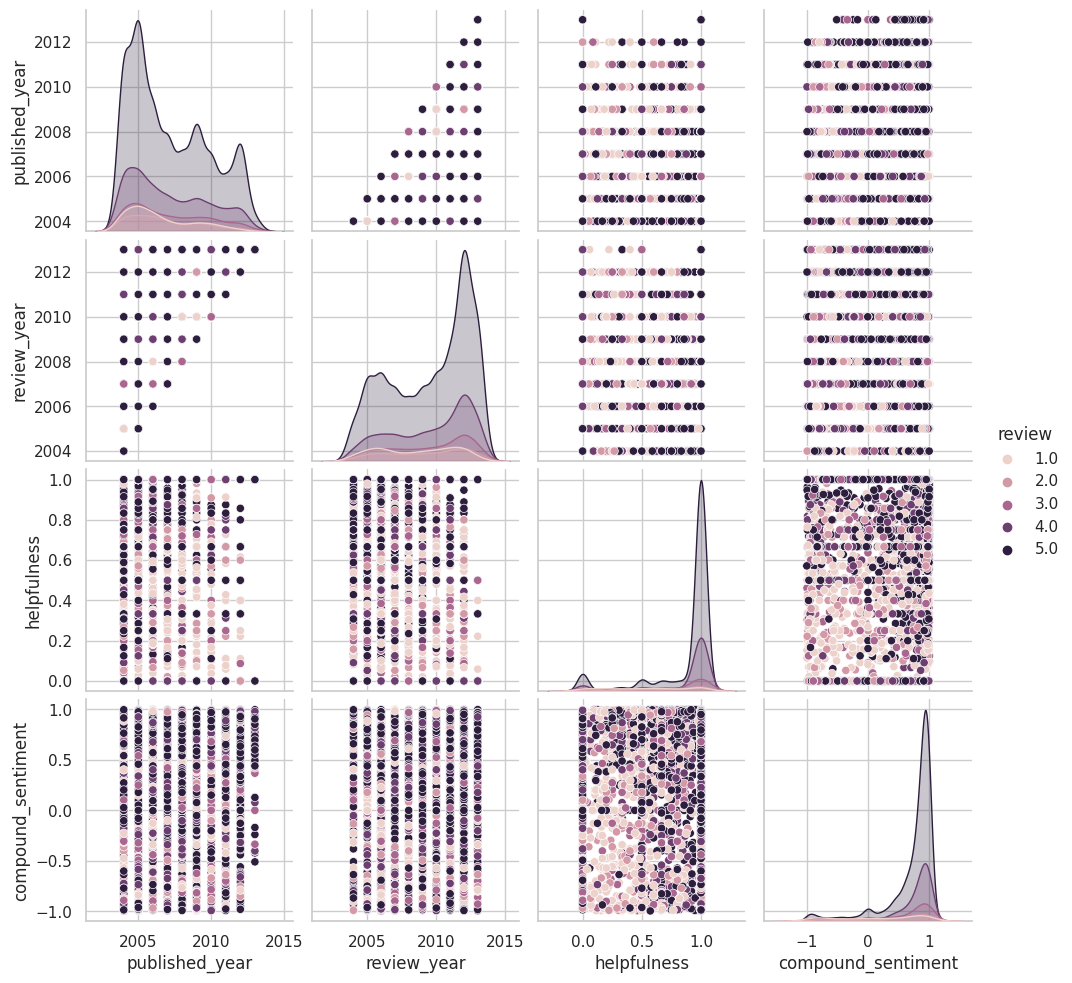

In [231]:
sns.pairplot(data=df_train, hue='review')
plt.show()

# Final Findings from EDA.

- Categorical features Authors, Publisher and Categories are biased to high score values. But have an important variability shown in the countplot figures. So, they will be kept. The model training and testing results with and without using the features, and the crossvalidation will determine if the variables should be removed.


# Model Selection, Training and Testing

- The current project is a regression exercise for predicting a continous value for the Review Score of the Review.
- The dataset contains multiple features. Some of the Categorical which are stored on lists (authors and Categories), a Cateogorical feature Publisher. 
- The dataset contains 4 numerical features, where we have discrete variables (published year, review_year) and continuos variables (helpfulness and compund_sentiment)
- Lastly, the dataset contains a text column that will be vectorized.

- Authors and Categories will be processed with One Hot Encoding, creating a Column for each category in the list. 
- Publisher will be encoded as well

In [232]:
X_train.sample(1)


categories           publisher  published_year  review_year  helpfulness  \
3558    Fiction  Simon and Schuster            2008         2008     0.333333   

                                                                       text_clean  \
3558  wonderful story written superbly book reading phillipa gregory could hardly   

      compound_sentiment  
3558              0.5719

In [233]:
# Preprocessing for text data
text_vectorizer = TfidfVectorizer()
text_features_train = text_vectorizer.fit_transform(X_train['text_clean'])
text_features_test = text_vectorizer.transform(X_test['text_clean'])

In [234]:
text_features_train

<11803x39987 sparse matrix of type '<class 'numpy.float64'>'
	with 586895 stored elements in Compressed Sparse Row format>

In [235]:
pca = PCA(n_components=5, random_state=2109)

In [236]:
text_features_train_pcaed = pca.fit_transform(text_features_train.toarray())
text_features_test_pcaed = pca.transform(text_features_test.toarray())

In [237]:
text_features_train_pcaed

array([[ 8.27097515e-02, -3.90588176e-02, -1.78602839e-01,
        -3.84324952e-02,  7.85257120e-02],
       [-1.60287998e-04, -5.84438605e-02, -2.06762914e-03,
         4.36107254e-02, -1.12145007e-02],
       [ 3.54024986e-02, -2.79192374e-02, -6.60225908e-02,
        -5.36147507e-02,  5.62017998e-02],
       ...,
       [-1.20771807e-02, -1.44726344e-01,  1.40133668e-01,
         1.34373237e-01, -1.48689991e-01],
       [-8.75361301e-02,  8.06658869e-03, -2.40385305e-02,
        -1.64780490e-02,  7.65020324e-02],
       [-3.66302681e-02, -2.08464019e-02,  5.90480818e-02,
        -7.70522198e-02,  5.60244613e-04]])

In [254]:
scaler = StandardScaler()
numerical_features_scaled_train = scaler.fit_transform(X_train[['published_year', 'review_year']])
numerical_features_scaled_test = scaler.transform(X_test[['published_year', 'review_year']])

In [255]:
numerical_features_nonscaled_train = X_train[['helpfulness', 'compound_sentiment']]
numerical_features_nonscaled_test = X_test[['helpfulness', 'compound_sentiment']]

published_year  review_year  helpfulness  compound_sentiment
1226             2005         2006     0.894737              0.9961
526              2005         2005     0.833333              0.4588
6045             2007         2008     1.000000             -0.9186
8743             2006         2006     0.666667              0.9888
6119             2006         2008     0.500000              0.9794
...               ...          ...          ...                 ...
14396            2005         2007     1.000000             -0.0790
2724             2009         2009     1.000000              0.9509
15426            2012         2013     1.000000              0.7964
5152             2007         2008     1.000000              0.1531
14826            2009         2011     0.000000              0.9098

[11803 rows x 4 columns]

In [240]:
enconder = OneHotEncoder()
categorical_features_train = enconder.fit_transform(X_train[['categories','publisher']])
categorical_features_test = enconder.transform(X_test[['categories','publisher']])

In [241]:
categorical_features_train

<11803x20 sparse matrix of type '<class 'numpy.float64'>'
	with 23606 stored elements in Compressed Sparse Row format>

In [299]:
X_train_final = np.concatenate((text_features_train_pcaed, categorical_features_train.toarray(), numerical_features_scaled_train, numerical_features_nonscaled_train), axis=1)
X_test_final = np.concatenate((text_features_test_pcaed, categorical_features_test.toarray(), numerical_features_scaled_test, numerical_features_nonscaled_test), axis=1)

# X_train_final = np.concatenate((text_features_train_pcaed, numerical_features_scaled_train, numerical_features_nonscaled_train), axis=1)
# X_test_final = np.concatenate((text_features_test_pcaed, numerical_features_scaled_test, numerical_features_nonscaled_test), axis=1)

# X_train_final = np.concatenate((text_features_train_pcaed, numerical_features_nonscaled_train), axis=1)
# X_test_final = np.concatenate((text_features_test_pcaed, numerical_features_nonscaled_test), axis=1)


In [293]:
X_train_final.shape

(11803, 9)

In [303]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()

In [304]:
model_rf.fit(X_train_final, y_train)

RandomForestRegressor()

In [305]:
y_hat_rfr = model_rf.predict(X_test_final)
y_hat_rfr

array([4.49, 3.8 , 2.85, ..., 4.62, 4.64, 3.48])

In [306]:
print(f"Random Forest Regressor: Mean squared error: {mean_squared_error(y_test, y_hat_rfr):.4f}")
print(f"Random Forest Regressor: Coefficient of determination: {r2_score(y_test, y_hat_rfr):.4f}")

Random Forest Regressor: Mean squared error: 1.3659
Random Forest Regressor: Coefficient of determination: 0.0407


In [300]:
from sklearn.svm import SVC
model_svm = SVC(kernel = "rbf", C = 1.0, gamma = 0.5)
model_svm.fit(X_train_final, y_train)

SVC(gamma=0.5)

In [301]:
y_pred_svm = model_svm.predict(X_test_final)
y_pred_svm

array([5., 5., 5., ..., 5., 5., 5.])

In [302]:
print(f"SVM: Mean squared error: {mean_squared_error(y_test, y_pred_svm):.4f}")
print(f"SVM: Coefficient of determination: {r2_score(y_test, y_pred_svm):.4f}")

SVM: Mean squared error: 2.0562
SVM: Coefficient of determination: -0.4441


In [279]:
from sklearn.linear_model import LinearRegression, Lasso
model_ls = Lasso(random_state=2014)

In [280]:
model_ls.fit(X_train_final, y_train)

Lasso(random_state=2014)

In [281]:
y_pred_lasso = model_ls.predict(X_test_final)
y_pred_lasso

array([4.2042701, 4.2042701, 4.2042701, ..., 4.2042701, 4.2042701,
       4.2042701])

In [282]:
print(f"Lasso: Mean squared error: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"Lasso: Coefficient of determination: {r2_score(y_test, y_pred_lasso):.4f}")

Lasso: Mean squared error: 1.4239
Lasso: Coefficient of determination: -0.0000


In [155]:
# label_encoder_publisher = LabelEncoder()

In [172]:
# vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=1.0)#min_df: Flotante de 0 a 1, Entero: La cuenta. cuantas veces tiene que haber aparecido la palabra para considerarla o eliminar

In [173]:
# X_train_text_clean_vec = vectorizer.fit_transform(X_train['text_clean'])

In [174]:
# X_train_text_clean_vec.shape

(11568, 10927)

In [176]:
# vectorizer.get_feature_names_out()

array(['aa', 'aacute', 'abandon', ..., 'zombies', 'zone', 'zoo'],
      dtype=object)

In [ ]:
# X_train['text_clean_vec']

In [187]:
# pca = PCA(n_components=5, random_state=2109)
# pca_vecs = pca.fit_transform(X_train_text_clean_vec.toarray())

In [188]:
# pca_df = pd.DataFrame()

# labels = y_train.reset_index(drop=True)

# pca_df['x_0'] = pca_vecs[:,0] #Todas las filas :,   | Columna 0
# pca_df['x_1'] = pca_vecs[:,1] #Todas las filas :,   | Columna 1
# pca_df['x_2'] = pca_vecs[:,2] #Todas las filas :,   | Columna 1
# pca_df['x_3'] = pca_vecs[:,3] #Todas las filas :,   | Columna 1
# pca_df['x_4'] = pca_vecs[:,4] #Todas las filas :,   | Columna 1
# pca_df['review'] = labels

In [153]:
# sns.scatterplot(data=pca_df, x='x_3', y='x_4', hue='review')

In [152]:
# pca_vecs